In [1]:
from custom_dataset.segdataset import InstanceSegmentationDataset
from torch.utils.data import DataLoader
import json

import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
import evaluate
import logging
from utils import rs_utils
from datetime import datetime
from transformers import SegformerImageProcessor
import numpy as np

In [2]:
#--- root 
root_dir = '/disk3/eric/dataset/Weapon_System/segmentation_pipes'

#--- time
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

In [3]:
#-----------
_VERSION = "030"
_EPOCHS = 100
_MODEL_SAVE = True
_MODEL_VERSION = "nvidia/mit-b5"
_MODEL_VERSION_SAVE = _MODEL_VERSION.split("/")[-1]
_BATCH_SIZE = 2
_DEVICE = "cuda:1"
#----------

In [4]:
# Set up a logger
log_dir = "/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/Segmentation_Pipes/logs"
os.makedirs(log_dir, exist_ok=True)
current_time = datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")
log_file_path = os.path.join(log_dir, f"Version_{_VERSION}_{_MODEL_VERSION_SAVE}_{formatted_time}.log")
logger = rs_utils.setup_logger("FewShotSeg", log_file_path, level=logging.INFO)

In [5]:
json_file = os.path.join(root_dir, 'train/_annotations.coco.json')
with open(json_file, 'r') as f:
    data = json.load(f)
#--- 
id2label = {
    0:data['categories'][0]['name'],
    1:data['categories'][1]['name'],
    2:data['categories'][2]['name'],
    3:data['categories'][3]['name'],
    4:data['categories'][4]['name']
}
id2label[0] = "background"
label2id = {v: k for k, v in id2label.items()}

In [6]:
label2id

{'background': 0,
 'M2A1Slammer': 1,
 'M5SandstormMLRS': 2,
 'T140Angara': 3,
 'ZamakMRL': 4}

In [7]:
#----------------------
# reduce_labels should be False !! 

image_processor = SegformerImageProcessor(reduce_labels=False,size={"height": 448, "width": 448})

train_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=_BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=_BATCH_SIZE)

/home/eric/anaconda3/envs/trex/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
# Support
sup_label = train_dataset.__getitem__(70)['labels']
sup_label.unique()

filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/images/city_part_23.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/labels/city_part_23.png


tensor([0, 1])

In [9]:
# Query
qry_label = train_dataset.__getitem__(74)['labels']
qry_label.unique()

filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/images/city_part_4.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/labels/city_part_4.png


tensor([0, 1, 2, 3, 4])

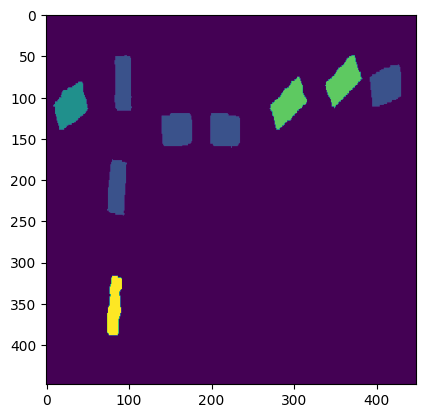

In [10]:
import matplotlib.pyplot as plt
plt.imshow(qry_label)

In [11]:
def convert_qry_label(sup_sample, qry_sample):
    sup_unique = [i for i in torch.unique(sup_sample) if i != 0][0]

    #-- mask 
    mask = (qry_sample == sup_unique)
    reverse_mask = (mask == False)

    qry_sample[mask] = 1
    qry_sample[reverse_mask] = 0
    
    return sup_sample, qry_sample

#----
sup_label, qry_label = convert_qry_label(sup_label, qry_label)

In [12]:
sup_label.unique()

tensor([0, 1])

In [13]:
qry_label.unique()

tensor([0, 1])

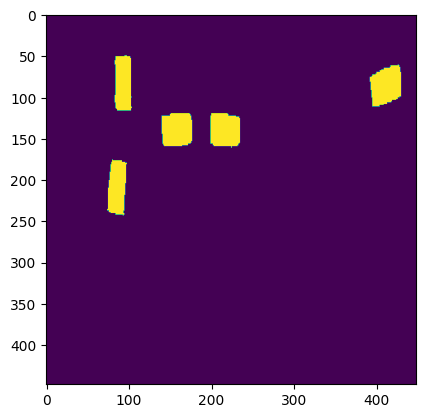

In [14]:
import matplotlib.pyplot as plt
plt.imshow(qry_label)

In [15]:
sup_label.unique()

# option 1
# => 단순화 하기 위한 조건.
# => sub_label 은 오직 1가지 종류의 label 만 가지고 있어야 한다.
# => 1가지 종류의 레이블만 가지고 있는 데이터들은?
# => json 에서 찾아보자. 
# => train set 77장 중에서 1 label only 로 가지고 있는 데이터는 70장. 

tensor([0, 1])

In [16]:
import collections
from itertools import product

Img_Dict = collections.defaultdict(list)
for anno in data['annotations']:
    #print(anno)
    Img_Dict[anno['image_id']].append(anno['category_id'])
    
single_label_imgs = []
multi_label_imgs = []
for k, v in Img_Dict.items():
    #print(k, v)
    if len(set(v)) == 1 :
        single_label_imgs.append(k)
    else:
        multi_label_imgs.append(k)
    #Img_Dict[k] = len(set(v))
combinations = list(product(single_label_imgs, multi_label_imgs))

In [17]:
single_label_imgs_names = []
multi_label_imgs_names = []
for img_ in data['images']:
    if img_['id'] in single_label_imgs:
        #print(img_)
        single_label_imgs_names.append(img_['file_name'].split(".")[0].replace("_png",".png"))
    elif img_['id'] in multi_label_imgs:
        multi_label_imgs_names.append(img_['file_name'].split(".")[0].replace("_png",".png"))

combinations_names = list(product(single_label_imgs_names, multi_label_imgs_names))

In [18]:
combinations_names

[('Zamak__part_21.png', 'city_part_4.png'),
 ('Zamak__part_21.png', 'city_part_9.png'),
 ('Zamak__part_21.png', 'city_part_13.png'),
 ('Zamak__part_21.png', 'city_part_10.png'),
 ('Zamak__part_21.png', 'city_part_24.png'),
 ('Zamak__part_21.png', 'city_part_3.png'),
 ('Zamak__part_21.png', 'city_part_19.png'),
 ('M2A1Slammer2__part_24.png', 'city_part_4.png'),
 ('M2A1Slammer2__part_24.png', 'city_part_9.png'),
 ('M2A1Slammer2__part_24.png', 'city_part_13.png'),
 ('M2A1Slammer2__part_24.png', 'city_part_10.png'),
 ('M2A1Slammer2__part_24.png', 'city_part_24.png'),
 ('M2A1Slammer2__part_24.png', 'city_part_3.png'),
 ('M2A1Slammer2__part_24.png', 'city_part_19.png'),
 ('Zamak__part_18.png', 'city_part_4.png'),
 ('Zamak__part_18.png', 'city_part_9.png'),
 ('Zamak__part_18.png', 'city_part_13.png'),
 ('Zamak__part_18.png', 'city_part_10.png'),
 ('Zamak__part_18.png', 'city_part_24.png'),
 ('Zamak__part_18.png', 'city_part_3.png'),
 ('Zamak__part_18.png', 'city_part_19.png'),
 ('M5Sandstorm_

In [19]:
len(single_label_imgs_names), len(multi_label_imgs)

(70, 7)

In [20]:
# option 2
# 가져온 image 들 의 label 을 보고, 맞는 label 만 바이너리로 남기기


In [21]:
import numpy as np
sup_sample=np.asarray([[0,0,
             2,0,]])

qry_sample=np.asarray([[1,1,
             2,2]])


In [22]:
sup_label.shape

torch.Size([448, 448])

In [23]:
sup_label

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [24]:
# Qry
qry_label = train_dataset.__getitem__(73)['labels']
print(qry_label.unique())

filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/images/city_part_3.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/labels/city_part_3.png
tensor([0, 1, 2, 3, 4])


In [25]:
qry_label.shape

torch.Size([448, 448])

In [26]:
qry_label

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [27]:
from custom_dataset.segdataset import FewShotSegDataset

In [28]:
train_dataset = InstanceSegmentationDataset(root_dir=root_dir, image_processor=image_processor)

segdataset_train = FewShotSegDataset(root_dir=root_dir, image_processor=image_processor)
segdataset_valid =  FewShotSegDataset(root_dir=root_dir, image_processor=image_processor,train=False)

In [29]:
s, q = segdataset_train.__getitem__(30)

filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/images/city_part_13.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/train/labels/city_part_13.png


In [30]:
s['labels'].unique()

tensor([0, 1])

In [47]:
s, q = segdataset_valid.__getitem__(3)

filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/images/M2A1Slammer2__part_18.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/labels/M2A1Slammer2__part_18.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/images/city_part_15.png
filename /disk3/eric/dataset/Weapon_System/segmentation_pipes/valid/labels/city_part_15.png


In [48]:
s['labels'].unique()

tensor([0, 1])

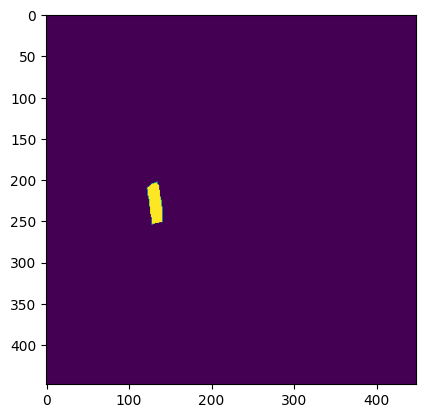

In [49]:
plt.imshow(s['labels'])

In [50]:
q['labels'].unique()

tensor([0, 1])

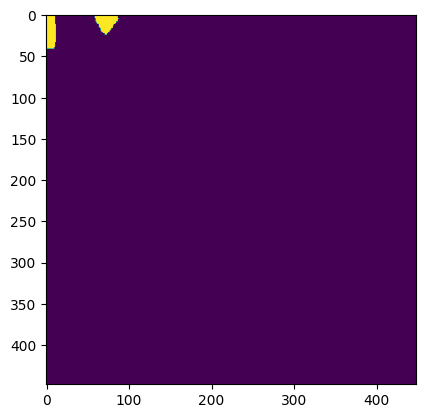

In [52]:
plt.imshow(q['labels'])

In [21]:
# define model
from models.custom_segformer import FewShotFormer

seg_model = FewShotFormer.from_pretrained(_MODEL_VERSION,
                                        num_labels=5,
                                        id2label=id2label,
                                        label2id=label2id,
                                        force_download=False)

Some weights of FewShotFormer were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
seg_model.config.hidden_sizes.append(1024)

In [23]:
seg_model.config.hidden_sizes

[64, 128, 320, 512, 1024]

In [24]:
seg_model.config.num_encoder_blocks = 5

In [25]:
seg_model.config.num_encoder_blocks

5

In [26]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

dinov2_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
#backbone_model.to(_DEVICE)

Using cache found in /home/eric/.cache/torch/hub/facebookresearch_dinov2_main


In [27]:
dinov2_model

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [28]:
# model freeze 
for param in dinov2_model.parameters():
    param.requires_grad = False

In [29]:
a1 = train_dataset.__getitem__(0)['pixel_values']
a1 = a1.unsqueeze(0)
#a1 = a1.to("cuda:0")

filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png


In [30]:
dino_hidden_states = dinov2_model.forward_features(a1)

In [31]:
dino_hidden_states.keys()

dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])

In [32]:
dino_hidden_states["x_norm_patchtokens"].shape

torch.Size([1, 1024, 1024])

In [33]:
patche_token = dino_hidden_states["x_norm_patchtokens"]

In [34]:
patche_token.reshape([1,-1,32,32]).shape

torch.Size([1, 1024, 32, 32])

In [35]:
patche_token.shape

torch.Size([1, 1024, 1024])

In [36]:
# define metric
metric = evaluate.load("mean_iou")
# define optimizer
optimizer = torch.optim.AdamW(seg_model.parameters(), lr=0.00006)

In [37]:
best_val_iou = 0 


#-- model to device
seg_model = seg_model.to(_DEVICE)
dinov2_model = dinov2_model.to(_DEVICE) 

#---
for epoch in range(_EPOCHS):  # loop over the dataset multiple times
    logger.info(f"Epoch: {epoch}")

    # Training loop
    for idx, batch in enumerate(train_dataloader):
        # get the inputs
        pixel_values = batch["pixel_values"].to(_DEVICE)
        labels = batch["labels"].to(_DEVICE)

        #-----
        patch_token = dinov2_model.forward_features(pixel_values)
        patch_token = patch_token["x_norm_patchtokens"]
        patch_token = patch_token.reshape([pixel_values.shape[0],-1,32,32])

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = seg_model(pixel_values=pixel_values, labels=labels,dino_features = patch_token)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # Evaluate periodically
        if idx % 100 == 0:
            with torch.no_grad():
                upsampled_logits = nn.functional.interpolate(
                    logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
                )
                predicted = upsampled_logits.argmax(dim=1)

                metrics = metric._compute(
                    predictions=predicted.cpu(),
                    references=labels.cpu(),
                    num_labels=len(id2label),
                    ignore_index=255,
                    reduce_labels=False,  # we've already reduced the labels ourselves
                )
                logger.info(
                    f"Epoch: {epoch}, "
                    f"Training Loss: {loss.item():.4f}, "
                    f"Mean IoU: {metrics['mean_iou']:.4f}, "
                    f"Mean Accuracy: {metrics['mean_accuracy']:.4f}"
                )
    # Validation loop
    val_loss = 0
    val_metrics = {"mean_iou": 0, "mean_accuracy": 0}
    for batch in valid_dataloader:
        pixel_values = batch["pixel_values"].to(_DEVICE)
        labels = batch["labels"].to(_DEVICE)

        with torch.no_grad():
            #-----
            patch_token = dinov2_model.forward_features(pixel_values)
            patch_token = patch_token["x_norm_patchtokens"]
            patch_token = patch_token.reshape([pixel_values.shape[0],-1,32,32])

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = seg_model(pixel_values=pixel_values, labels=labels,dino_features = patch_token)
            loss, logits = outputs.loss, outputs.logits
                
            #--------------            
            val_loss += outputs.loss.item()

            upsampled_logits = nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            predicted = upsampled_logits.argmax(dim=1)

            batch_metrics = metric._compute(
                predictions=predicted.cpu(),
                references=labels.cpu(),
                num_labels=len(id2label),
                ignore_index=255,
                reduce_labels=False,
            )
            val_metrics["mean_iou"] += batch_metrics["mean_iou"]
            val_metrics["mean_accuracy"] += batch_metrics["mean_accuracy"]

    # Average validation loss and metrics
    val_loss /= len(valid_dataloader)
    val_metrics["mean_iou"] /= len(valid_dataloader)
    val_metrics["mean_accuracy"] /= len(valid_dataloader)

    logger.info(
        f"Epoch : {epoch}, "
        f"Validation Results - Loss: {val_loss:.4f}, "
        f"Mean IoU: {val_metrics['mean_iou']:.4f}, "
        f"Mean Accuracy: {val_metrics['mean_accuracy']:.4f}"
    )

    # Save the model if the validation IoU improves
    if val_metrics["mean_iou"] > best_val_iou:
        best_val_iou = val_metrics["mean_iou"]
        
        if _MODEL_SAVE:
            torch.save(
                seg_model.state_dict(),
                os.path.join(
                    "/disk3/eric/checkpoints/military_fewshot_seg",
                    f"{_VERSION}_{_MODEL_VERSION_SAVE}_segformer_best_epoch_{epoch}_miou_{best_val_iou:.4f}.pt",
                ),
            )
        logger.info("Model saved!")


2024-11-25 16:51:08 - FewShotSeg - INFO - Epoch: 0
2024-11-25 16:51:08 - FewShotSeg - INFO - Epoch: 0


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png


/home/eric/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
2024-11-25 16:51:08 - FewShotSeg - INFO - Epoch: 0, Training Loss: 1.5576, Mean IoU: 0.0693, Mean Accuracy: 0.1852
2024-11-25 16:51:08 - FewShotSeg - INFO - Epoch: 0, Training Loss: 1.5576, Mean IoU: 0.0693, Mean Accuracy: 0.1852


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5San

/home/eric/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images/M2A1Slammer2__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/labels/M2A1Slammer2__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images/M2A1Slammer2__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/labels/M2A1Slammer2__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images/M2A1Slammer2__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/labels/M2A1Slammer2__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images/M5Sandstorm__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/labels/M5Sandstorm__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/valid/images/M5Sandstorm__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/W

2024-11-25 16:51:21 - FewShotSeg - INFO - Epoch : 0, Validation Results - Loss: 0.0307, Mean IoU: 0.4760, Mean Accuracy: 0.4792
2024-11-25 16:51:21 - FewShotSeg - INFO - Epoch : 0, Validation Results - Loss: 0.0307, Mean IoU: 0.4760, Mean Accuracy: 0.4792
2024-11-25 16:51:21 - FewShotSeg - INFO - Model saved!
2024-11-25 16:51:21 - FewShotSeg - INFO - Model saved!
2024-11-25 16:51:21 - FewShotSeg - INFO - Epoch: 1
2024-11-25 16:51:21 - FewShotSeg - INFO - Epoch: 1


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png


2024-11-25 16:51:21 - FewShotSeg - INFO - Epoch: 1, Training Loss: 0.0186, Mean IoU: 0.3320, Mean Accuracy: 0.3333
2024-11-25 16:51:21 - FewShotSeg - INFO - Epoch: 1, Training Loss: 0.0186, Mean IoU: 0.3320, Mean Accuracy: 0.3333


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_

2024-11-25 16:51:34 - FewShotSeg - INFO - Epoch : 1, Validation Results - Loss: 0.0183, Mean IoU: 0.4542, Mean Accuracy: 0.4884
2024-11-25 16:51:34 - FewShotSeg - INFO - Epoch : 1, Validation Results - Loss: 0.0183, Mean IoU: 0.4542, Mean Accuracy: 0.4884
2024-11-25 16:51:34 - FewShotSeg - INFO - Epoch: 2
2024-11-25 16:51:34 - FewShotSeg - INFO - Epoch: 2


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png


2024-11-25 16:51:34 - FewShotSeg - INFO - Epoch: 2, Training Loss: 0.0116, Mean IoU: 0.3324, Mean Accuracy: 0.3333
2024-11-25 16:51:34 - FewShotSeg - INFO - Epoch: 2, Training Loss: 0.0116, Mean IoU: 0.3324, Mean Accuracy: 0.3333


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPO

2024-11-25 16:51:46 - FewShotSeg - INFO - Epoch : 2, Validation Results - Loss: 0.0154, Mean IoU: 0.5095, Mean Accuracy: 0.6188
2024-11-25 16:51:46 - FewShotSeg - INFO - Epoch : 2, Validation Results - Loss: 0.0154, Mean IoU: 0.5095, Mean Accuracy: 0.6188
2024-11-25 16:51:47 - FewShotSeg - INFO - Model saved!
2024-11-25 16:51:47 - FewShotSeg - INFO - Model saved!
2024-11-25 16:51:47 - FewShotSeg - INFO - Epoch: 3
2024-11-25 16:51:47 - FewShotSeg - INFO - Epoch: 3


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png


2024-11-25 16:51:47 - FewShotSeg - INFO - Epoch: 3, Training Loss: 0.0184, Mean IoU: 0.4172, Mean Accuracy: 0.5665
2024-11-25 16:51:47 - FewShotSeg - INFO - Epoch: 3, Training Loss: 0.0184, Mean IoU: 0.4172, Mean Accuracy: 0.5665


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5

2024-11-25 16:52:00 - FewShotSeg - INFO - Epoch : 3, Validation Results - Loss: 0.0123, Mean IoU: 0.6641, Mean Accuracy: 0.7630
2024-11-25 16:52:00 - FewShotSeg - INFO - Epoch : 3, Validation Results - Loss: 0.0123, Mean IoU: 0.6641, Mean Accuracy: 0.7630
2024-11-25 16:52:00 - FewShotSeg - INFO - Model saved!
2024-11-25 16:52:00 - FewShotSeg - INFO - Model saved!
2024-11-25 16:52:00 - FewShotSeg - INFO - Epoch: 4
2024-11-25 16:52:00 - FewShotSeg - INFO - Epoch: 4


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png


2024-11-25 16:52:00 - FewShotSeg - INFO - Epoch: 4, Training Loss: 0.0134, Mean IoU: 0.2489, Mean Accuracy: 0.5000
2024-11-25 16:52:00 - FewShotSeg - INFO - Epoch: 4, Training Loss: 0.0134, Mean IoU: 0.2489, Mean Accuracy: 0.5000


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/trai

2024-11-25 16:52:13 - FewShotSeg - INFO - Epoch : 4, Validation Results - Loss: 0.0095, Mean IoU: 0.6954, Mean Accuracy: 0.7546
2024-11-25 16:52:13 - FewShotSeg - INFO - Epoch : 4, Validation Results - Loss: 0.0095, Mean IoU: 0.6954, Mean Accuracy: 0.7546
2024-11-25 16:52:13 - FewShotSeg - INFO - Model saved!
2024-11-25 16:52:13 - FewShotSeg - INFO - Model saved!
2024-11-25 16:52:13 - FewShotSeg - INFO - Epoch: 5
2024-11-25 16:52:13 - FewShotSeg - INFO - Epoch: 5


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_23.png


2024-11-25 16:52:14 - FewShotSeg - INFO - Epoch: 5, Training Loss: 0.0037, Mean IoU: 0.6190, Mean Accuracy: 0.6195
2024-11-25 16:52:14 - FewShotSeg - INFO - Epoch: 5, Training Loss: 0.0037, Mean IoU: 0.6190, Mean Accuracy: 0.6195


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/

2024-11-25 16:52:27 - FewShotSeg - INFO - Epoch : 5, Validation Results - Loss: 0.0074, Mean IoU: 0.7831, Mean Accuracy: 0.8496
2024-11-25 16:52:27 - FewShotSeg - INFO - Epoch : 5, Validation Results - Loss: 0.0074, Mean IoU: 0.7831, Mean Accuracy: 0.8496
2024-11-25 16:52:27 - FewShotSeg - INFO - Model saved!
2024-11-25 16:52:27 - FewShotSeg - INFO - Model saved!
2024-11-25 16:52:27 - FewShotSeg - INFO - Epoch: 6
2024-11-25 16:52:27 - FewShotSeg - INFO - Epoch: 6


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_17.png


2024-11-25 16:52:27 - FewShotSeg - INFO - Epoch: 6, Training Loss: 0.0066, Mean IoU: 0.6223, Mean Accuracy: 0.9078
2024-11-25 16:52:27 - FewShotSeg - INFO - Epoch: 6, Training Loss: 0.0066, Mean IoU: 0.6223, Mean Accuracy: 0.9078


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/tra

2024-11-25 16:52:40 - FewShotSeg - INFO - Epoch : 6, Validation Results - Loss: 0.0074, Mean IoU: 0.7409, Mean Accuracy: 0.7956
2024-11-25 16:52:40 - FewShotSeg - INFO - Epoch : 6, Validation Results - Loss: 0.0074, Mean IoU: 0.7409, Mean Accuracy: 0.7956
2024-11-25 16:52:40 - FewShotSeg - INFO - Epoch: 7
2024-11-25 16:52:40 - FewShotSeg - INFO - Epoch: 7


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png


2024-11-25 16:52:40 - FewShotSeg - INFO - Epoch: 7, Training Loss: 0.0047, Mean IoU: 0.8005, Mean Accuracy: 0.8590
2024-11-25 16:52:40 - FewShotSeg - INFO - Epoch: 7, Training Loss: 0.0047, Mean IoU: 0.8005, Mean Accuracy: 0.8590


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation

2024-11-25 16:52:53 - FewShotSeg - INFO - Epoch : 7, Validation Results - Loss: 0.0057, Mean IoU: 0.8090, Mean Accuracy: 0.8581
2024-11-25 16:52:53 - FewShotSeg - INFO - Epoch : 7, Validation Results - Loss: 0.0057, Mean IoU: 0.8090, Mean Accuracy: 0.8581
2024-11-25 16:52:53 - FewShotSeg - INFO - Model saved!
2024-11-25 16:52:53 - FewShotSeg - INFO - Model saved!
2024-11-25 16:52:53 - FewShotSeg - INFO - Epoch: 8
2024-11-25 16:52:53 - FewShotSeg - INFO - Epoch: 8


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png


2024-11-25 16:52:54 - FewShotSeg - INFO - Epoch: 8, Training Loss: 0.0041, Mean IoU: 0.8924, Mean Accuracy: 0.9564
2024-11-25 16:52:54 - FewShotSeg - INFO - Epoch: 8, Training Loss: 0.0041, Mean IoU: 0.8924, Mean Accuracy: 0.9564


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentat

2024-11-25 16:53:06 - FewShotSeg - INFO - Epoch : 8, Validation Results - Loss: 0.0048, Mean IoU: 0.8379, Mean Accuracy: 0.8910
2024-11-25 16:53:06 - FewShotSeg - INFO - Epoch : 8, Validation Results - Loss: 0.0048, Mean IoU: 0.8379, Mean Accuracy: 0.8910
2024-11-25 16:53:07 - FewShotSeg - INFO - Model saved!
2024-11-25 16:53:07 - FewShotSeg - INFO - Model saved!
2024-11-25 16:53:07 - FewShotSeg - INFO - Epoch: 9
2024-11-25 16:53:07 - FewShotSeg - INFO - Epoch: 9


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png


2024-11-25 16:53:07 - FewShotSeg - INFO - Epoch: 9, Training Loss: 0.0026, Mean IoU: 0.8567, Mean Accuracy: 0.9541
2024-11-25 16:53:07 - FewShotSeg - INFO - Epoch: 9, Training Loss: 0.0026, Mean IoU: 0.8567, Mean Accuracy: 0.9541


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentat

2024-11-25 16:53:20 - FewShotSeg - INFO - Epoch : 9, Validation Results - Loss: 0.0049, Mean IoU: 0.7896, Mean Accuracy: 0.8597
2024-11-25 16:53:20 - FewShotSeg - INFO - Epoch : 9, Validation Results - Loss: 0.0049, Mean IoU: 0.7896, Mean Accuracy: 0.8597
2024-11-25 16:53:20 - FewShotSeg - INFO - Epoch: 10
2024-11-25 16:53:20 - FewShotSeg - INFO - Epoch: 10


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_8.png


2024-11-25 16:53:20 - FewShotSeg - INFO - Epoch: 10, Training Loss: 0.0051, Mean IoU: 0.8706, Mean Accuracy: 0.9370
2024-11-25 16:53:20 - FewShotSeg - INFO - Epoch: 10, Training Loss: 0.0051, Mean IoU: 0.8706, Mean Accuracy: 0.9370


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_p

2024-11-25 16:53:33 - FewShotSeg - INFO - Epoch : 10, Validation Results - Loss: 0.0048, Mean IoU: 0.7961, Mean Accuracy: 0.8649
2024-11-25 16:53:33 - FewShotSeg - INFO - Epoch : 10, Validation Results - Loss: 0.0048, Mean IoU: 0.7961, Mean Accuracy: 0.8649
2024-11-25 16:53:33 - FewShotSeg - INFO - Epoch: 11
2024-11-25 16:53:33 - FewShotSeg - INFO - Epoch: 11


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_25.png


2024-11-25 16:53:33 - FewShotSeg - INFO - Epoch: 11, Training Loss: 0.0029, Mean IoU: 0.9080, Mean Accuracy: 0.9682
2024-11-25 16:53:33 - FewShotSeg - INFO - Epoch: 11, Training Loss: 0.0029, Mean IoU: 0.9080, Mean Accuracy: 0.9682


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe

2024-11-25 16:53:46 - FewShotSeg - INFO - Epoch : 11, Validation Results - Loss: 0.0044, Mean IoU: 0.8202, Mean Accuracy: 0.8899
2024-11-25 16:53:46 - FewShotSeg - INFO - Epoch : 11, Validation Results - Loss: 0.0044, Mean IoU: 0.8202, Mean Accuracy: 0.8899
2024-11-25 16:53:46 - FewShotSeg - INFO - Epoch: 12
2024-11-25 16:53:46 - FewShotSeg - INFO - Epoch: 12


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_20.png


2024-11-25 16:53:47 - FewShotSeg - INFO - Epoch: 12, Training Loss: 0.0022, Mean IoU: 0.9260, Mean Accuracy: 0.9721
2024-11-25 16:53:47 - FewShotSeg - INFO - Epoch: 12, Training Loss: 0.0022, Mean IoU: 0.9260, Mean Accuracy: 0.9721


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_p

2024-11-25 16:53:59 - FewShotSeg - INFO - Epoch : 12, Validation Results - Loss: 0.0046, Mean IoU: 0.8486, Mean Accuracy: 0.8736
2024-11-25 16:53:59 - FewShotSeg - INFO - Epoch : 12, Validation Results - Loss: 0.0046, Mean IoU: 0.8486, Mean Accuracy: 0.8736
2024-11-25 16:54:00 - FewShotSeg - INFO - Model saved!
2024-11-25 16:54:00 - FewShotSeg - INFO - Model saved!
2024-11-25 16:54:00 - FewShotSeg - INFO - Epoch: 13
2024-11-25 16:54:00 - FewShotSeg - INFO - Epoch: 13


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png


2024-11-25 16:54:00 - FewShotSeg - INFO - Epoch: 13, Training Loss: 0.0014, Mean IoU: 0.9244, Mean Accuracy: 0.9564
2024-11-25 16:54:00 - FewShotSeg - INFO - Epoch: 13, Training Loss: 0.0014, Mean IoU: 0.9244, Mean Accuracy: 0.9564


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentat

2024-11-25 16:54:13 - FewShotSeg - INFO - Epoch : 13, Validation Results - Loss: 0.0047, Mean IoU: 0.7999, Mean Accuracy: 0.8638
2024-11-25 16:54:13 - FewShotSeg - INFO - Epoch : 13, Validation Results - Loss: 0.0047, Mean IoU: 0.7999, Mean Accuracy: 0.8638
2024-11-25 16:54:13 - FewShotSeg - INFO - Epoch: 14
2024-11-25 16:54:13 - FewShotSeg - INFO - Epoch: 14


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png


2024-11-25 16:54:13 - FewShotSeg - INFO - Epoch: 14, Training Loss: 0.0031, Mean IoU: 0.9170, Mean Accuracy: 0.9469
2024-11-25 16:54:13 - FewShotSeg - INFO - Epoch: 14, Training Loss: 0.0031, Mean IoU: 0.9170, Mean Accuracy: 0.9469


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/trai

2024-11-25 16:54:26 - FewShotSeg - INFO - Epoch : 14, Validation Results - Loss: 0.0045, Mean IoU: 0.8484, Mean Accuracy: 0.8722
2024-11-25 16:54:26 - FewShotSeg - INFO - Epoch : 14, Validation Results - Loss: 0.0045, Mean IoU: 0.8484, Mean Accuracy: 0.8722
2024-11-25 16:54:26 - FewShotSeg - INFO - Epoch: 15
2024-11-25 16:54:26 - FewShotSeg - INFO - Epoch: 15


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png


2024-11-25 16:54:26 - FewShotSeg - INFO - Epoch: 15, Training Loss: 0.0012, Mean IoU: 0.9509, Mean Accuracy: 0.9739
2024-11-25 16:54:26 - FewShotSeg - INFO - Epoch: 15, Training Loss: 0.0012, Mean IoU: 0.9509, Mean Accuracy: 0.9739


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pi

2024-11-25 16:54:39 - FewShotSeg - INFO - Epoch : 15, Validation Results - Loss: 0.0043, Mean IoU: 0.8193, Mean Accuracy: 0.8774
2024-11-25 16:54:39 - FewShotSeg - INFO - Epoch : 15, Validation Results - Loss: 0.0043, Mean IoU: 0.8193, Mean Accuracy: 0.8774
2024-11-25 16:54:39 - FewShotSeg - INFO - Epoch: 16
2024-11-25 16:54:39 - FewShotSeg - INFO - Epoch: 16


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png


2024-11-25 16:54:39 - FewShotSeg - INFO - Epoch: 16, Training Loss: 0.0013, Mean IoU: 0.9076, Mean Accuracy: 0.9414
2024-11-25 16:54:39 - FewShotSeg - INFO - Epoch: 16, Training Loss: 0.0013, Mean IoU: 0.9076, Mean Accuracy: 0.9414


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/tra

2024-11-25 16:54:52 - FewShotSeg - INFO - Epoch : 16, Validation Results - Loss: 0.0062, Mean IoU: 0.7916, Mean Accuracy: 0.8130
2024-11-25 16:54:52 - FewShotSeg - INFO - Epoch : 16, Validation Results - Loss: 0.0062, Mean IoU: 0.7916, Mean Accuracy: 0.8130
2024-11-25 16:54:52 - FewShotSeg - INFO - Epoch: 17
2024-11-25 16:54:52 - FewShotSeg - INFO - Epoch: 17


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png


2024-11-25 16:54:52 - FewShotSeg - INFO - Epoch: 17, Training Loss: 0.0030, Mean IoU: 0.9004, Mean Accuracy: 0.9283
2024-11-25 16:54:52 - FewShotSeg - INFO - Epoch: 17, Training Loss: 0.0030, Mean IoU: 0.9004, Mean Accuracy: 0.9283


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/

2024-11-25 16:55:05 - FewShotSeg - INFO - Epoch : 17, Validation Results - Loss: 0.0038, Mean IoU: 0.8712, Mean Accuracy: 0.8936
2024-11-25 16:55:05 - FewShotSeg - INFO - Epoch : 17, Validation Results - Loss: 0.0038, Mean IoU: 0.8712, Mean Accuracy: 0.8936
2024-11-25 16:55:05 - FewShotSeg - INFO - Model saved!
2024-11-25 16:55:05 - FewShotSeg - INFO - Model saved!
2024-11-25 16:55:05 - FewShotSeg - INFO - Epoch: 18
2024-11-25 16:55:05 - FewShotSeg - INFO - Epoch: 18


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png


2024-11-25 16:55:05 - FewShotSeg - INFO - Epoch: 18, Training Loss: 0.0012, Mean IoU: 0.9305, Mean Accuracy: 0.9452
2024-11-25 16:55:05 - FewShotSeg - INFO - Epoch: 18, Training Loss: 0.0012, Mean IoU: 0.9305, Mean Accuracy: 0.9452


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part

2024-11-25 16:55:18 - FewShotSeg - INFO - Epoch : 18, Validation Results - Loss: 0.0053, Mean IoU: 0.8180, Mean Accuracy: 0.8375
2024-11-25 16:55:18 - FewShotSeg - INFO - Epoch : 18, Validation Results - Loss: 0.0053, Mean IoU: 0.8180, Mean Accuracy: 0.8375
2024-11-25 16:55:18 - FewShotSeg - INFO - Epoch: 19
2024-11-25 16:55:18 - FewShotSeg - INFO - Epoch: 19


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_4.png


2024-11-25 16:55:18 - FewShotSeg - INFO - Epoch: 19, Training Loss: 0.0016, Mean IoU: 0.9143, Mean Accuracy: 0.9216
2024-11-25 16:55:18 - FewShotSeg - INFO - Epoch: 19, Training Loss: 0.0016, Mean IoU: 0.9143, Mean Accuracy: 0.9216


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segment

2024-11-25 16:55:31 - FewShotSeg - INFO - Epoch : 19, Validation Results - Loss: 0.0036, Mean IoU: 0.8292, Mean Accuracy: 0.9145
2024-11-25 16:55:31 - FewShotSeg - INFO - Epoch : 19, Validation Results - Loss: 0.0036, Mean IoU: 0.8292, Mean Accuracy: 0.9145
2024-11-25 16:55:31 - FewShotSeg - INFO - Epoch: 20
2024-11-25 16:55:31 - FewShotSeg - INFO - Epoch: 20


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_11.png


2024-11-25 16:55:31 - FewShotSeg - INFO - Epoch: 20, Training Loss: 0.0028, Mean IoU: 0.8909, Mean Accuracy: 0.9857
2024-11-25 16:55:31 - FewShotSeg - INFO - Epoch: 20, Training Loss: 0.0028, Mean IoU: 0.8909, Mean Accuracy: 0.9857


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/

2024-11-25 16:55:44 - FewShotSeg - INFO - Epoch : 20, Validation Results - Loss: 0.0039, Mean IoU: 0.8751, Mean Accuracy: 0.8990
2024-11-25 16:55:44 - FewShotSeg - INFO - Epoch : 20, Validation Results - Loss: 0.0039, Mean IoU: 0.8751, Mean Accuracy: 0.8990
2024-11-25 16:55:44 - FewShotSeg - INFO - Model saved!
2024-11-25 16:55:44 - FewShotSeg - INFO - Model saved!
2024-11-25 16:55:44 - FewShotSeg - INFO - Epoch: 21
2024-11-25 16:55:44 - FewShotSeg - INFO - Epoch: 21


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png


2024-11-25 16:55:45 - FewShotSeg - INFO - Epoch: 21, Training Loss: 0.0027, Mean IoU: 0.9468, Mean Accuracy: 0.9807
2024-11-25 16:55:45 - FewShotSeg - INFO - Epoch: 21, Training Loss: 0.0027, Mean IoU: 0.9468, Mean Accuracy: 0.9807


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/tr

2024-11-25 16:55:57 - FewShotSeg - INFO - Epoch : 21, Validation Results - Loss: 0.0039, Mean IoU: 0.8719, Mean Accuracy: 0.8877
2024-11-25 16:55:57 - FewShotSeg - INFO - Epoch : 21, Validation Results - Loss: 0.0039, Mean IoU: 0.8719, Mean Accuracy: 0.8877
2024-11-25 16:55:57 - FewShotSeg - INFO - Epoch: 22
2024-11-25 16:55:57 - FewShotSeg - INFO - Epoch: 22


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_21.png


2024-11-25 16:55:58 - FewShotSeg - INFO - Epoch: 22, Training Loss: 0.0018, Mean IoU: 0.9399, Mean Accuracy: 0.9526
2024-11-25 16:55:58 - FewShotSeg - INFO - Epoch: 22, Training Loss: 0.0018, Mean IoU: 0.9399, Mean Accuracy: 0.9526


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segme

2024-11-25 16:56:10 - FewShotSeg - INFO - Epoch : 22, Validation Results - Loss: 0.0036, Mean IoU: 0.8799, Mean Accuracy: 0.9035
2024-11-25 16:56:10 - FewShotSeg - INFO - Epoch : 22, Validation Results - Loss: 0.0036, Mean IoU: 0.8799, Mean Accuracy: 0.9035
2024-11-25 16:56:11 - FewShotSeg - INFO - Model saved!
2024-11-25 16:56:11 - FewShotSeg - INFO - Model saved!
2024-11-25 16:56:11 - FewShotSeg - INFO - Epoch: 23
2024-11-25 16:56:11 - FewShotSeg - INFO - Epoch: 23


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_17.png


2024-11-25 16:56:11 - FewShotSeg - INFO - Epoch: 23, Training Loss: 0.0010, Mean IoU: 0.9267, Mean Accuracy: 0.9586
2024-11-25 16:56:11 - FewShotSeg - INFO - Epoch: 23, Training Loss: 0.0010, Mean IoU: 0.9267, Mean Accuracy: 0.9586


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_

2024-11-25 16:56:23 - FewShotSeg - INFO - Epoch : 23, Validation Results - Loss: 0.0037, Mean IoU: 0.8785, Mean Accuracy: 0.9010
2024-11-25 16:56:23 - FewShotSeg - INFO - Epoch : 23, Validation Results - Loss: 0.0037, Mean IoU: 0.8785, Mean Accuracy: 0.9010
2024-11-25 16:56:23 - FewShotSeg - INFO - Epoch: 24
2024-11-25 16:56:23 - FewShotSeg - INFO - Epoch: 24


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png


2024-11-25 16:56:24 - FewShotSeg - INFO - Epoch: 24, Training Loss: 0.0010, Mean IoU: 0.9399, Mean Accuracy: 0.9710
2024-11-25 16:56:24 - FewShotSeg - INFO - Epoch: 24, Training Loss: 0.0010, Mean IoU: 0.9399, Mean Accuracy: 0.9710


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAP

2024-11-25 16:56:36 - FewShotSeg - INFO - Epoch : 24, Validation Results - Loss: 0.0037, Mean IoU: 0.8753, Mean Accuracy: 0.8956
2024-11-25 16:56:36 - FewShotSeg - INFO - Epoch : 24, Validation Results - Loss: 0.0037, Mean IoU: 0.8753, Mean Accuracy: 0.8956
2024-11-25 16:56:36 - FewShotSeg - INFO - Epoch: 25
2024-11-25 16:56:36 - FewShotSeg - INFO - Epoch: 25


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png


2024-11-25 16:56:37 - FewShotSeg - INFO - Epoch: 25, Training Loss: 0.0020, Mean IoU: 0.9284, Mean Accuracy: 0.9636
2024-11-25 16:56:37 - FewShotSeg - INFO - Epoch: 25, Training Loss: 0.0020, Mean IoU: 0.9284, Mean Accuracy: 0.9636


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_p

2024-11-25 16:56:49 - FewShotSeg - INFO - Epoch : 25, Validation Results - Loss: 0.0036, Mean IoU: 0.8801, Mean Accuracy: 0.9047
2024-11-25 16:56:49 - FewShotSeg - INFO - Epoch : 25, Validation Results - Loss: 0.0036, Mean IoU: 0.8801, Mean Accuracy: 0.9047
2024-11-25 16:56:50 - FewShotSeg - INFO - Model saved!
2024-11-25 16:56:50 - FewShotSeg - INFO - Model saved!
2024-11-25 16:56:50 - FewShotSeg - INFO - Epoch: 26
2024-11-25 16:56:50 - FewShotSeg - INFO - Epoch: 26


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png


2024-11-25 16:56:50 - FewShotSeg - INFO - Epoch: 26, Training Loss: 0.0030, Mean IoU: 0.9584, Mean Accuracy: 0.9801
2024-11-25 16:56:50 - FewShotSeg - INFO - Epoch: 26, Training Loss: 0.0030, Mean IoU: 0.9584, Mean Accuracy: 0.9801


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pip

2024-11-25 16:57:03 - FewShotSeg - INFO - Epoch : 26, Validation Results - Loss: 0.0037, Mean IoU: 0.8787, Mean Accuracy: 0.9013
2024-11-25 16:57:03 - FewShotSeg - INFO - Epoch : 26, Validation Results - Loss: 0.0037, Mean IoU: 0.8787, Mean Accuracy: 0.9013
2024-11-25 16:57:03 - FewShotSeg - INFO - Epoch: 27
2024-11-25 16:57:03 - FewShotSeg - INFO - Epoch: 27


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_4.png


2024-11-25 16:57:03 - FewShotSeg - INFO - Epoch: 27, Training Loss: 0.0009, Mean IoU: 0.9634, Mean Accuracy: 0.9854
2024-11-25 16:57:03 - FewShotSeg - INFO - Epoch: 27, Training Loss: 0.0009, Mean IoU: 0.9634, Mean Accuracy: 0.9854


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/

2024-11-25 16:57:16 - FewShotSeg - INFO - Epoch : 27, Validation Results - Loss: 0.0033, Mean IoU: 0.8896, Mean Accuracy: 0.9185
2024-11-25 16:57:16 - FewShotSeg - INFO - Epoch : 27, Validation Results - Loss: 0.0033, Mean IoU: 0.8896, Mean Accuracy: 0.9185
2024-11-25 16:57:16 - FewShotSeg - INFO - Model saved!
2024-11-25 16:57:16 - FewShotSeg - INFO - Model saved!
2024-11-25 16:57:16 - FewShotSeg - INFO - Epoch: 28
2024-11-25 16:57:16 - FewShotSeg - INFO - Epoch: 28


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png


2024-11-25 16:57:17 - FewShotSeg - INFO - Epoch: 28, Training Loss: 0.0009, Mean IoU: 0.9451, Mean Accuracy: 0.9845
2024-11-25 16:57:17 - FewShotSeg - INFO - Epoch: 28, Training Loss: 0.0009, Mean IoU: 0.9451, Mean Accuracy: 0.9845


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/

2024-11-25 16:57:29 - FewShotSeg - INFO - Epoch : 28, Validation Results - Loss: 0.0036, Mean IoU: 0.8841, Mean Accuracy: 0.9070
2024-11-25 16:57:29 - FewShotSeg - INFO - Epoch : 28, Validation Results - Loss: 0.0036, Mean IoU: 0.8841, Mean Accuracy: 0.9070
2024-11-25 16:57:29 - FewShotSeg - INFO - Epoch: 29
2024-11-25 16:57:29 - FewShotSeg - INFO - Epoch: 29


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_4.png


2024-11-25 16:57:30 - FewShotSeg - INFO - Epoch: 29, Training Loss: 0.0011, Mean IoU: 0.9313, Mean Accuracy: 0.9645
2024-11-25 16:57:30 - FewShotSeg - INFO - Epoch: 29, Training Loss: 0.0011, Mean IoU: 0.9313, Mean Accuracy: 0.9645


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_p

2024-11-25 16:57:42 - FewShotSeg - INFO - Epoch : 29, Validation Results - Loss: 0.0036, Mean IoU: 0.8846, Mean Accuracy: 0.9079
2024-11-25 16:57:42 - FewShotSeg - INFO - Epoch : 29, Validation Results - Loss: 0.0036, Mean IoU: 0.8846, Mean Accuracy: 0.9079
2024-11-25 16:57:42 - FewShotSeg - INFO - Epoch: 30
2024-11-25 16:57:42 - FewShotSeg - INFO - Epoch: 30


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_19.png


2024-11-25 16:57:43 - FewShotSeg - INFO - Epoch: 30, Training Loss: 0.0013, Mean IoU: 0.9647, Mean Accuracy: 0.9782
2024-11-25 16:57:43 - FewShotSeg - INFO - Epoch: 30, Training Loss: 0.0013, Mean IoU: 0.9647, Mean Accuracy: 0.9782


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/tr

2024-11-25 16:57:55 - FewShotSeg - INFO - Epoch : 30, Validation Results - Loss: 0.0045, Mean IoU: 0.8614, Mean Accuracy: 0.8731
2024-11-25 16:57:55 - FewShotSeg - INFO - Epoch : 30, Validation Results - Loss: 0.0045, Mean IoU: 0.8614, Mean Accuracy: 0.8731
2024-11-25 16:57:55 - FewShotSeg - INFO - Epoch: 31
2024-11-25 16:57:55 - FewShotSeg - INFO - Epoch: 31


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png


2024-11-25 16:57:56 - FewShotSeg - INFO - Epoch: 31, Training Loss: 0.0012, Mean IoU: 0.9185, Mean Accuracy: 0.9412
2024-11-25 16:57:56 - FewShotSeg - INFO - Epoch: 31, Training Loss: 0.0012, Mean IoU: 0.9185, Mean Accuracy: 0.9412


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmenta

2024-11-25 16:58:08 - FewShotSeg - INFO - Epoch : 31, Validation Results - Loss: 0.0039, Mean IoU: 0.8750, Mean Accuracy: 0.8907
2024-11-25 16:58:08 - FewShotSeg - INFO - Epoch : 31, Validation Results - Loss: 0.0039, Mean IoU: 0.8750, Mean Accuracy: 0.8907
2024-11-25 16:58:08 - FewShotSeg - INFO - Epoch: 32
2024-11-25 16:58:08 - FewShotSeg - INFO - Epoch: 32


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_15.png


2024-11-25 16:58:09 - FewShotSeg - INFO - Epoch: 32, Training Loss: 0.0021, Mean IoU: 0.9355, Mean Accuracy: 0.9604
2024-11-25 16:58:09 - FewShotSeg - INFO - Epoch: 32, Training Loss: 0.0021, Mean IoU: 0.9355, Mean Accuracy: 0.9604


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON

2024-11-25 16:58:21 - FewShotSeg - INFO - Epoch : 32, Validation Results - Loss: 0.0040, Mean IoU: 0.8767, Mean Accuracy: 0.8952
2024-11-25 16:58:21 - FewShotSeg - INFO - Epoch : 32, Validation Results - Loss: 0.0040, Mean IoU: 0.8767, Mean Accuracy: 0.8952
2024-11-25 16:58:21 - FewShotSeg - INFO - Epoch: 33
2024-11-25 16:58:21 - FewShotSeg - INFO - Epoch: 33


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png


2024-11-25 16:58:22 - FewShotSeg - INFO - Epoch: 33, Training Loss: 0.0008, Mean IoU: 0.9231, Mean Accuracy: 0.9566
2024-11-25 16:58:22 - FewShotSeg - INFO - Epoch: 33, Training Loss: 0.0008, Mean IoU: 0.9231, Mean Accuracy: 0.9566


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/s

2024-11-25 16:58:34 - FewShotSeg - INFO - Epoch : 33, Validation Results - Loss: 0.0036, Mean IoU: 0.8847, Mean Accuracy: 0.8999
2024-11-25 16:58:34 - FewShotSeg - INFO - Epoch : 33, Validation Results - Loss: 0.0036, Mean IoU: 0.8847, Mean Accuracy: 0.8999
2024-11-25 16:58:34 - FewShotSeg - INFO - Epoch: 34
2024-11-25 16:58:34 - FewShotSeg - INFO - Epoch: 34


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png


2024-11-25 16:58:35 - FewShotSeg - INFO - Epoch: 34, Training Loss: 0.0013, Mean IoU: 0.9391, Mean Accuracy: 0.9513
2024-11-25 16:58:35 - FewShotSeg - INFO - Epoch: 34, Training Loss: 0.0013, Mean IoU: 0.9391, Mean Accuracy: 0.9513


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/

2024-11-25 16:58:47 - FewShotSeg - INFO - Epoch : 34, Validation Results - Loss: 0.0038, Mean IoU: 0.8827, Mean Accuracy: 0.8983
2024-11-25 16:58:47 - FewShotSeg - INFO - Epoch : 34, Validation Results - Loss: 0.0038, Mean IoU: 0.8827, Mean Accuracy: 0.8983
2024-11-25 16:58:47 - FewShotSeg - INFO - Epoch: 35
2024-11-25 16:58:47 - FewShotSeg - INFO - Epoch: 35


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png


2024-11-25 16:58:48 - FewShotSeg - INFO - Epoch: 35, Training Loss: 0.0009, Mean IoU: 0.9073, Mean Accuracy: 0.9202
2024-11-25 16:58:48 - FewShotSeg - INFO - Epoch: 35, Training Loss: 0.0009, Mean IoU: 0.9073, Mean Accuracy: 0.9202


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON

2024-11-25 16:59:00 - FewShotSeg - INFO - Epoch : 35, Validation Results - Loss: 0.0029, Mean IoU: 0.8562, Mean Accuracy: 0.9387
2024-11-25 16:59:00 - FewShotSeg - INFO - Epoch : 35, Validation Results - Loss: 0.0029, Mean IoU: 0.8562, Mean Accuracy: 0.9387
2024-11-25 16:59:00 - FewShotSeg - INFO - Epoch: 36
2024-11-25 16:59:00 - FewShotSeg - INFO - Epoch: 36


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png


2024-11-25 16:59:00 - FewShotSeg - INFO - Epoch: 36, Training Loss: 0.0024, Mean IoU: 0.9549, Mean Accuracy: 0.9917
2024-11-25 16:59:00 - FewShotSeg - INFO - Epoch: 36, Training Loss: 0.0024, Mean IoU: 0.9549, Mean Accuracy: 0.9917


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/l

2024-11-25 16:59:13 - FewShotSeg - INFO - Epoch : 36, Validation Results - Loss: 0.0042, Mean IoU: 0.8685, Mean Accuracy: 0.8799
2024-11-25 16:59:13 - FewShotSeg - INFO - Epoch : 36, Validation Results - Loss: 0.0042, Mean IoU: 0.8685, Mean Accuracy: 0.8799
2024-11-25 16:59:13 - FewShotSeg - INFO - Epoch: 37
2024-11-25 16:59:13 - FewShotSeg - INFO - Epoch: 37


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_21.png


2024-11-25 16:59:13 - FewShotSeg - INFO - Epoch: 37, Training Loss: 0.0036, Mean IoU: 0.9159, Mean Accuracy: 0.9213
2024-11-25 16:59:13 - FewShotSeg - INFO - Epoch: 37, Training Loss: 0.0036, Mean IoU: 0.9159, Mean Accuracy: 0.9213


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentati

2024-11-25 16:59:26 - FewShotSeg - INFO - Epoch : 37, Validation Results - Loss: 0.0033, Mean IoU: 0.8945, Mean Accuracy: 0.9114
2024-11-25 16:59:26 - FewShotSeg - INFO - Epoch : 37, Validation Results - Loss: 0.0033, Mean IoU: 0.8945, Mean Accuracy: 0.9114
2024-11-25 16:59:26 - FewShotSeg - INFO - Model saved!
2024-11-25 16:59:26 - FewShotSeg - INFO - Model saved!
2024-11-25 16:59:26 - FewShotSeg - INFO - Epoch: 38
2024-11-25 16:59:26 - FewShotSeg - INFO - Epoch: 38


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png


2024-11-25 16:59:27 - FewShotSeg - INFO - Epoch: 38, Training Loss: 0.0015, Mean IoU: 0.9346, Mean Accuracy: 0.9709
2024-11-25 16:59:27 - FewShotSeg - INFO - Epoch: 38, Training Loss: 0.0015, Mean IoU: 0.9346, Mean Accuracy: 0.9709


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmen

2024-11-25 16:59:39 - FewShotSeg - INFO - Epoch : 38, Validation Results - Loss: 0.0034, Mean IoU: 0.8900, Mean Accuracy: 0.9092
2024-11-25 16:59:39 - FewShotSeg - INFO - Epoch : 38, Validation Results - Loss: 0.0034, Mean IoU: 0.8900, Mean Accuracy: 0.9092
2024-11-25 16:59:39 - FewShotSeg - INFO - Epoch: 39
2024-11-25 16:59:39 - FewShotSeg - INFO - Epoch: 39


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_9.png


2024-11-25 16:59:40 - FewShotSeg - INFO - Epoch: 39, Training Loss: 0.0020, Mean IoU: 0.9392, Mean Accuracy: 0.9715
2024-11-25 16:59:40 - FewShotSeg - INFO - Epoch: 39, Training Loss: 0.0020, Mean IoU: 0.9392, Mean Accuracy: 0.9715


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentati

2024-11-25 16:59:52 - FewShotSeg - INFO - Epoch : 39, Validation Results - Loss: 0.0029, Mean IoU: 0.8757, Mean Accuracy: 0.9422
2024-11-25 16:59:52 - FewShotSeg - INFO - Epoch : 39, Validation Results - Loss: 0.0029, Mean IoU: 0.8757, Mean Accuracy: 0.9422
2024-11-25 16:59:52 - FewShotSeg - INFO - Epoch: 40
2024-11-25 16:59:52 - FewShotSeg - INFO - Epoch: 40


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png


2024-11-25 16:59:53 - FewShotSeg - INFO - Epoch: 40, Training Loss: 0.0018, Mean IoU: 0.9403, Mean Accuracy: 0.9869
2024-11-25 16:59:53 - FewShotSeg - INFO - Epoch: 40, Training Loss: 0.0018, Mean IoU: 0.9403, Mean Accuracy: 0.9869


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentatio

2024-11-25 17:00:06 - FewShotSeg - INFO - Epoch : 40, Validation Results - Loss: 0.0038, Mean IoU: 0.8856, Mean Accuracy: 0.9035
2024-11-25 17:00:06 - FewShotSeg - INFO - Epoch : 40, Validation Results - Loss: 0.0038, Mean IoU: 0.8856, Mean Accuracy: 0.9035
2024-11-25 17:00:06 - FewShotSeg - INFO - Epoch: 41
2024-11-25 17:00:06 - FewShotSeg - INFO - Epoch: 41


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png


2024-11-25 17:00:06 - FewShotSeg - INFO - Epoch: 41, Training Loss: 0.0010, Mean IoU: 0.9554, Mean Accuracy: 0.9745
2024-11-25 17:00:06 - FewShotSeg - INFO - Epoch: 41, Training Loss: 0.0010, Mean IoU: 0.9554, Mean Accuracy: 0.9745


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/label

2024-11-25 17:00:18 - FewShotSeg - INFO - Epoch : 41, Validation Results - Loss: 0.0035, Mean IoU: 0.8923, Mean Accuracy: 0.9110
2024-11-25 17:00:18 - FewShotSeg - INFO - Epoch : 41, Validation Results - Loss: 0.0035, Mean IoU: 0.8923, Mean Accuracy: 0.9110
2024-11-25 17:00:19 - FewShotSeg - INFO - Epoch: 42
2024-11-25 17:00:19 - FewShotSeg - INFO - Epoch: 42


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png


2024-11-25 17:00:19 - FewShotSeg - INFO - Epoch: 42, Training Loss: 0.0017, Mean IoU: 0.9742, Mean Accuracy: 0.9887
2024-11-25 17:00:19 - FewShotSeg - INFO - Epoch: 42, Training Loss: 0.0017, Mean IoU: 0.9742, Mean Accuracy: 0.9887


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_p

2024-11-25 17:00:32 - FewShotSeg - INFO - Epoch : 42, Validation Results - Loss: 0.0038, Mean IoU: 0.8860, Mean Accuracy: 0.9019
2024-11-25 17:00:32 - FewShotSeg - INFO - Epoch : 42, Validation Results - Loss: 0.0038, Mean IoU: 0.8860, Mean Accuracy: 0.9019
2024-11-25 17:00:32 - FewShotSeg - INFO - Epoch: 43
2024-11-25 17:00:32 - FewShotSeg - INFO - Epoch: 43


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png


2024-11-25 17:00:32 - FewShotSeg - INFO - Epoch: 43, Training Loss: 0.0019, Mean IoU: 0.9683, Mean Accuracy: 0.9759
2024-11-25 17:00:32 - FewShotSeg - INFO - Epoch: 43, Training Loss: 0.0019, Mean IoU: 0.9683, Mean Accuracy: 0.9759


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentati

2024-11-25 17:00:44 - FewShotSeg - INFO - Epoch : 43, Validation Results - Loss: 0.0037, Mean IoU: 0.8894, Mean Accuracy: 0.9088
2024-11-25 17:00:44 - FewShotSeg - INFO - Epoch : 43, Validation Results - Loss: 0.0037, Mean IoU: 0.8894, Mean Accuracy: 0.9088
2024-11-25 17:00:44 - FewShotSeg - INFO - Epoch: 44
2024-11-25 17:00:44 - FewShotSeg - INFO - Epoch: 44


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_17.png


2024-11-25 17:00:45 - FewShotSeg - INFO - Epoch: 44, Training Loss: 0.0016, Mean IoU: 0.9588, Mean Accuracy: 0.9878
2024-11-25 17:00:45 - FewShotSeg - INFO - Epoch: 44, Training Loss: 0.0016, Mean IoU: 0.9588, Mean Accuracy: 0.9878


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pi

2024-11-25 17:00:57 - FewShotSeg - INFO - Epoch : 44, Validation Results - Loss: 0.0039, Mean IoU: 0.8875, Mean Accuracy: 0.9020
2024-11-25 17:00:57 - FewShotSeg - INFO - Epoch : 44, Validation Results - Loss: 0.0039, Mean IoU: 0.8875, Mean Accuracy: 0.9020
2024-11-25 17:00:57 - FewShotSeg - INFO - Epoch: 45
2024-11-25 17:00:57 - FewShotSeg - INFO - Epoch: 45


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png


2024-11-25 17:00:58 - FewShotSeg - INFO - Epoch: 45, Training Loss: 0.0013, Mean IoU: 0.9553, Mean Accuracy: 0.9672
2024-11-25 17:00:58 - FewShotSeg - INFO - Epoch: 45, Training Loss: 0.0013, Mean IoU: 0.9553, Mean Accuracy: 0.9672


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe

2024-11-25 17:01:10 - FewShotSeg - INFO - Epoch : 45, Validation Results - Loss: 0.0034, Mean IoU: 0.8985, Mean Accuracy: 0.9186
2024-11-25 17:01:10 - FewShotSeg - INFO - Epoch : 45, Validation Results - Loss: 0.0034, Mean IoU: 0.8985, Mean Accuracy: 0.9186
2024-11-25 17:01:11 - FewShotSeg - INFO - Model saved!
2024-11-25 17:01:11 - FewShotSeg - INFO - Model saved!
2024-11-25 17:01:11 - FewShotSeg - INFO - Epoch: 46
2024-11-25 17:01:11 - FewShotSeg - INFO - Epoch: 46


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png


2024-11-25 17:01:11 - FewShotSeg - INFO - Epoch: 46, Training Loss: 0.0012, Mean IoU: 0.9459, Mean Accuracy: 0.9704
2024-11-25 17:01:11 - FewShotSeg - INFO - Epoch: 46, Training Loss: 0.0012, Mean IoU: 0.9459, Mean Accuracy: 0.9704


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/

2024-11-25 17:01:24 - FewShotSeg - INFO - Epoch : 46, Validation Results - Loss: 0.0036, Mean IoU: 0.8926, Mean Accuracy: 0.9088
2024-11-25 17:01:24 - FewShotSeg - INFO - Epoch : 46, Validation Results - Loss: 0.0036, Mean IoU: 0.8926, Mean Accuracy: 0.9088
2024-11-25 17:01:24 - FewShotSeg - INFO - Epoch: 47
2024-11-25 17:01:24 - FewShotSeg - INFO - Epoch: 47


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_9.png


2024-11-25 17:01:24 - FewShotSeg - INFO - Epoch: 47, Training Loss: 0.0020, Mean IoU: 0.9663, Mean Accuracy: 0.9773
2024-11-25 17:01:24 - FewShotSeg - INFO - Epoch: 47, Training Loss: 0.0020, Mean IoU: 0.9663, Mean Accuracy: 0.9773


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentat

2024-11-25 17:01:37 - FewShotSeg - INFO - Epoch : 47, Validation Results - Loss: 0.0033, Mean IoU: 0.8984, Mean Accuracy: 0.9196
2024-11-25 17:01:37 - FewShotSeg - INFO - Epoch : 47, Validation Results - Loss: 0.0033, Mean IoU: 0.8984, Mean Accuracy: 0.9196
2024-11-25 17:01:37 - FewShotSeg - INFO - Epoch: 48
2024-11-25 17:01:37 - FewShotSeg - INFO - Epoch: 48


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png


2024-11-25 17:01:37 - FewShotSeg - INFO - Epoch: 48, Training Loss: 0.0010, Mean IoU: 0.9565, Mean Accuracy: 0.9806
2024-11-25 17:01:37 - FewShotSeg - INFO - Epoch: 48, Training Loss: 0.0010, Mean IoU: 0.9565, Mean Accuracy: 0.9806


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe

2024-11-25 17:01:50 - FewShotSeg - INFO - Epoch : 48, Validation Results - Loss: 0.0033, Mean IoU: 0.9006, Mean Accuracy: 0.9221
2024-11-25 17:01:50 - FewShotSeg - INFO - Epoch : 48, Validation Results - Loss: 0.0033, Mean IoU: 0.9006, Mean Accuracy: 0.9221
2024-11-25 17:01:50 - FewShotSeg - INFO - Model saved!
2024-11-25 17:01:50 - FewShotSeg - INFO - Model saved!
2024-11-25 17:01:50 - FewShotSeg - INFO - Epoch: 49
2024-11-25 17:01:50 - FewShotSeg - INFO - Epoch: 49


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png


2024-11-25 17:01:51 - FewShotSeg - INFO - Epoch: 49, Training Loss: 0.0009, Mean IoU: 0.9579, Mean Accuracy: 0.9787
2024-11-25 17:01:51 - FewShotSeg - INFO - Epoch: 49, Training Loss: 0.0009, Mean IoU: 0.9579, Mean Accuracy: 0.9787


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_p

2024-11-25 17:02:03 - FewShotSeg - INFO - Epoch : 49, Validation Results - Loss: 0.0038, Mean IoU: 0.8909, Mean Accuracy: 0.9080
2024-11-25 17:02:03 - FewShotSeg - INFO - Epoch : 49, Validation Results - Loss: 0.0038, Mean IoU: 0.8909, Mean Accuracy: 0.9080
2024-11-25 17:02:03 - FewShotSeg - INFO - Epoch: 50
2024-11-25 17:02:03 - FewShotSeg - INFO - Epoch: 50


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_14.png


2024-11-25 17:02:04 - FewShotSeg - INFO - Epoch: 50, Training Loss: 0.0016, Mean IoU: 0.9723, Mean Accuracy: 0.9855
2024-11-25 17:02:04 - FewShotSeg - INFO - Epoch: 50, Training Loss: 0.0016, Mean IoU: 0.9723, Mean Accuracy: 0.9855


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmen

2024-11-25 17:02:16 - FewShotSeg - INFO - Epoch : 50, Validation Results - Loss: 0.0034, Mean IoU: 0.8968, Mean Accuracy: 0.9179
2024-11-25 17:02:16 - FewShotSeg - INFO - Epoch : 50, Validation Results - Loss: 0.0034, Mean IoU: 0.8968, Mean Accuracy: 0.9179
2024-11-25 17:02:16 - FewShotSeg - INFO - Epoch: 51
2024-11-25 17:02:16 - FewShotSeg - INFO - Epoch: 51


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png


2024-11-25 17:02:17 - FewShotSeg - INFO - Epoch: 51, Training Loss: 0.0013, Mean IoU: 0.9567, Mean Accuracy: 0.9829
2024-11-25 17:02:17 - FewShotSeg - INFO - Epoch: 51, Training Loss: 0.0013, Mean IoU: 0.9567, Mean Accuracy: 0.9829


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/se

2024-11-25 17:02:29 - FewShotSeg - INFO - Epoch : 51, Validation Results - Loss: 0.0041, Mean IoU: 0.8853, Mean Accuracy: 0.8992
2024-11-25 17:02:29 - FewShotSeg - INFO - Epoch : 51, Validation Results - Loss: 0.0041, Mean IoU: 0.8853, Mean Accuracy: 0.8992
2024-11-25 17:02:29 - FewShotSeg - INFO - Epoch: 52
2024-11-25 17:02:29 - FewShotSeg - INFO - Epoch: 52


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png


2024-11-25 17:02:30 - FewShotSeg - INFO - Epoch: 52, Training Loss: 0.0017, Mean IoU: 0.9621, Mean Accuracy: 0.9759
2024-11-25 17:02:30 - FewShotSeg - INFO - Epoch: 52, Training Loss: 0.0017, Mean IoU: 0.9621, Mean Accuracy: 0.9759


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pip

2024-11-25 17:02:42 - FewShotSeg - INFO - Epoch : 52, Validation Results - Loss: 0.0031, Mean IoU: 0.8671, Mean Accuracy: 0.9329
2024-11-25 17:02:42 - FewShotSeg - INFO - Epoch : 52, Validation Results - Loss: 0.0031, Mean IoU: 0.8671, Mean Accuracy: 0.9329
2024-11-25 17:02:42 - FewShotSeg - INFO - Epoch: 53
2024-11-25 17:02:42 - FewShotSeg - INFO - Epoch: 53


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png


2024-11-25 17:02:43 - FewShotSeg - INFO - Epoch: 53, Training Loss: 0.0013, Mean IoU: 0.9483, Mean Accuracy: 0.9770
2024-11-25 17:02:43 - FewShotSeg - INFO - Epoch: 53, Training Loss: 0.0013, Mean IoU: 0.9483, Mean Accuracy: 0.9770


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pip

2024-11-25 17:02:55 - FewShotSeg - INFO - Epoch : 53, Validation Results - Loss: 0.0033, Mean IoU: 0.9023, Mean Accuracy: 0.9270
2024-11-25 17:02:55 - FewShotSeg - INFO - Epoch : 53, Validation Results - Loss: 0.0033, Mean IoU: 0.9023, Mean Accuracy: 0.9270
2024-11-25 17:02:56 - FewShotSeg - INFO - Model saved!
2024-11-25 17:02:56 - FewShotSeg - INFO - Model saved!
2024-11-25 17:02:56 - FewShotSeg - INFO - Epoch: 54
2024-11-25 17:02:56 - FewShotSeg - INFO - Epoch: 54


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png


2024-11-25 17:02:56 - FewShotSeg - INFO - Epoch: 54, Training Loss: 0.0016, Mean IoU: 0.9625, Mean Accuracy: 0.9907
2024-11-25 17:02:56 - FewShotSeg - INFO - Epoch: 54, Training Loss: 0.0016, Mean IoU: 0.9625, Mean Accuracy: 0.9907


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation

2024-11-25 17:03:09 - FewShotSeg - INFO - Epoch : 54, Validation Results - Loss: 0.0040, Mean IoU: 0.8907, Mean Accuracy: 0.9075
2024-11-25 17:03:09 - FewShotSeg - INFO - Epoch : 54, Validation Results - Loss: 0.0040, Mean IoU: 0.8907, Mean Accuracy: 0.9075
2024-11-25 17:03:09 - FewShotSeg - INFO - Epoch: 55
2024-11-25 17:03:09 - FewShotSeg - INFO - Epoch: 55


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png


2024-11-25 17:03:09 - FewShotSeg - INFO - Epoch: 55, Training Loss: 0.0013, Mean IoU: 0.9567, Mean Accuracy: 0.9694
2024-11-25 17:03:09 - FewShotSeg - INFO - Epoch: 55, Training Loss: 0.0013, Mean IoU: 0.9567, Mean Accuracy: 0.9694


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pip

2024-11-25 17:03:22 - FewShotSeg - INFO - Epoch : 55, Validation Results - Loss: 0.0032, Mean IoU: 0.9064, Mean Accuracy: 0.9292
2024-11-25 17:03:22 - FewShotSeg - INFO - Epoch : 55, Validation Results - Loss: 0.0032, Mean IoU: 0.9064, Mean Accuracy: 0.9292
2024-11-25 17:03:22 - FewShotSeg - INFO - Model saved!
2024-11-25 17:03:22 - FewShotSeg - INFO - Model saved!
2024-11-25 17:03:22 - FewShotSeg - INFO - Epoch: 56
2024-11-25 17:03:22 - FewShotSeg - INFO - Epoch: 56


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png


2024-11-25 17:03:23 - FewShotSeg - INFO - Epoch: 56, Training Loss: 0.0009, Mean IoU: 0.9190, Mean Accuracy: 0.9786
2024-11-25 17:03:23 - FewShotSeg - INFO - Epoch: 56, Training Loss: 0.0009, Mean IoU: 0.9190, Mean Accuracy: 0.9786


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAP

2024-11-25 17:03:35 - FewShotSeg - INFO - Epoch : 56, Validation Results - Loss: 0.0042, Mean IoU: 0.8858, Mean Accuracy: 0.8980
2024-11-25 17:03:35 - FewShotSeg - INFO - Epoch : 56, Validation Results - Loss: 0.0042, Mean IoU: 0.8858, Mean Accuracy: 0.8980
2024-11-25 17:03:35 - FewShotSeg - INFO - Epoch: 57
2024-11-25 17:03:35 - FewShotSeg - INFO - Epoch: 57


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_19.png


2024-11-25 17:03:36 - FewShotSeg - INFO - Epoch: 57, Training Loss: 0.0008, Mean IoU: 0.9277, Mean Accuracy: 0.9295
2024-11-25 17:03:36 - FewShotSeg - INFO - Epoch: 57, Training Loss: 0.0008, Mean IoU: 0.9277, Mean Accuracy: 0.9295


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation

2024-11-25 17:03:48 - FewShotSeg - INFO - Epoch : 57, Validation Results - Loss: 0.0035, Mean IoU: 0.8922, Mean Accuracy: 0.9138
2024-11-25 17:03:48 - FewShotSeg - INFO - Epoch : 57, Validation Results - Loss: 0.0035, Mean IoU: 0.8922, Mean Accuracy: 0.9138
2024-11-25 17:03:48 - FewShotSeg - INFO - Epoch: 58
2024-11-25 17:03:48 - FewShotSeg - INFO - Epoch: 58


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png


2024-11-25 17:03:49 - FewShotSeg - INFO - Epoch: 58, Training Loss: 0.0011, Mean IoU: 0.9489, Mean Accuracy: 0.9880
2024-11-25 17:03:49 - FewShotSeg - INFO - Epoch: 58, Training Loss: 0.0011, Mean IoU: 0.9489, Mean Accuracy: 0.9880


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/

2024-11-25 17:04:01 - FewShotSeg - INFO - Epoch : 58, Validation Results - Loss: 0.0032, Mean IoU: 0.9076, Mean Accuracy: 0.9336
2024-11-25 17:04:01 - FewShotSeg - INFO - Epoch : 58, Validation Results - Loss: 0.0032, Mean IoU: 0.9076, Mean Accuracy: 0.9336
2024-11-25 17:04:02 - FewShotSeg - INFO - Model saved!
2024-11-25 17:04:02 - FewShotSeg - INFO - Model saved!
2024-11-25 17:04:02 - FewShotSeg - INFO - Epoch: 59
2024-11-25 17:04:02 - FewShotSeg - INFO - Epoch: 59


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png


2024-11-25 17:04:02 - FewShotSeg - INFO - Epoch: 59, Training Loss: 0.0017, Mean IoU: 0.9522, Mean Accuracy: 0.9889
2024-11-25 17:04:02 - FewShotSeg - INFO - Epoch: 59, Training Loss: 0.0017, Mean IoU: 0.9522, Mean Accuracy: 0.9889


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentati

2024-11-25 17:04:15 - FewShotSeg - INFO - Epoch : 59, Validation Results - Loss: 0.0032, Mean IoU: 0.9106, Mean Accuracy: 0.9322
2024-11-25 17:04:15 - FewShotSeg - INFO - Epoch : 59, Validation Results - Loss: 0.0032, Mean IoU: 0.9106, Mean Accuracy: 0.9322
2024-11-25 17:04:15 - FewShotSeg - INFO - Model saved!
2024-11-25 17:04:15 - FewShotSeg - INFO - Model saved!
2024-11-25 17:04:15 - FewShotSeg - INFO - Epoch: 60
2024-11-25 17:04:15 - FewShotSeg - INFO - Epoch: 60


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png


2024-11-25 17:04:15 - FewShotSeg - INFO - Epoch: 60, Training Loss: 0.0010, Mean IoU: 0.9604, Mean Accuracy: 0.9831
2024-11-25 17:04:15 - FewShotSeg - INFO - Epoch: 60, Training Loss: 0.0010, Mean IoU: 0.9604, Mean Accuracy: 0.9831


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe

2024-11-25 17:04:28 - FewShotSeg - INFO - Epoch : 60, Validation Results - Loss: 0.0038, Mean IoU: 0.8958, Mean Accuracy: 0.9105
2024-11-25 17:04:28 - FewShotSeg - INFO - Epoch : 60, Validation Results - Loss: 0.0038, Mean IoU: 0.8958, Mean Accuracy: 0.9105
2024-11-25 17:04:28 - FewShotSeg - INFO - Epoch: 61
2024-11-25 17:04:28 - FewShotSeg - INFO - Epoch: 61


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png


2024-11-25 17:04:28 - FewShotSeg - INFO - Epoch: 61, Training Loss: 0.0015, Mean IoU: 0.9489, Mean Accuracy: 0.9581
2024-11-25 17:04:28 - FewShotSeg - INFO - Epoch: 61, Training Loss: 0.0015, Mean IoU: 0.9489, Mean Accuracy: 0.9581


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/t

2024-11-25 17:04:41 - FewShotSeg - INFO - Epoch : 61, Validation Results - Loss: 0.0036, Mean IoU: 0.8999, Mean Accuracy: 0.9165
2024-11-25 17:04:41 - FewShotSeg - INFO - Epoch : 61, Validation Results - Loss: 0.0036, Mean IoU: 0.8999, Mean Accuracy: 0.9165
2024-11-25 17:04:41 - FewShotSeg - INFO - Epoch: 62
2024-11-25 17:04:41 - FewShotSeg - INFO - Epoch: 62


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png


2024-11-25 17:04:41 - FewShotSeg - INFO - Epoch: 62, Training Loss: 0.0010, Mean IoU: 0.9461, Mean Accuracy: 0.9739
2024-11-25 17:04:41 - FewShotSeg - INFO - Epoch: 62, Training Loss: 0.0010, Mean IoU: 0.9461, Mean Accuracy: 0.9739


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_

2024-11-25 17:04:54 - FewShotSeg - INFO - Epoch : 62, Validation Results - Loss: 0.0033, Mean IoU: 0.8667, Mean Accuracy: 0.9288
2024-11-25 17:04:54 - FewShotSeg - INFO - Epoch : 62, Validation Results - Loss: 0.0033, Mean IoU: 0.8667, Mean Accuracy: 0.9288
2024-11-25 17:04:54 - FewShotSeg - INFO - Epoch: 63
2024-11-25 17:04:54 - FewShotSeg - INFO - Epoch: 63


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png


2024-11-25 17:04:54 - FewShotSeg - INFO - Epoch: 63, Training Loss: 0.0008, Mean IoU: 0.9378, Mean Accuracy: 0.9917
2024-11-25 17:04:54 - FewShotSeg - INFO - Epoch: 63, Training Loss: 0.0008, Mean IoU: 0.9378, Mean Accuracy: 0.9917


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe

2024-11-25 17:05:07 - FewShotSeg - INFO - Epoch : 63, Validation Results - Loss: 0.0042, Mean IoU: 0.8891, Mean Accuracy: 0.9037
2024-11-25 17:05:07 - FewShotSeg - INFO - Epoch : 63, Validation Results - Loss: 0.0042, Mean IoU: 0.8891, Mean Accuracy: 0.9037
2024-11-25 17:05:07 - FewShotSeg - INFO - Epoch: 64
2024-11-25 17:05:07 - FewShotSeg - INFO - Epoch: 64


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png


2024-11-25 17:05:07 - FewShotSeg - INFO - Epoch: 64, Training Loss: 0.0008, Mean IoU: 0.9653, Mean Accuracy: 0.9866
2024-11-25 17:05:07 - FewShotSeg - INFO - Epoch: 64, Training Loss: 0.0008, Mean IoU: 0.9653, Mean Accuracy: 0.9866


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmenta

2024-11-25 17:05:20 - FewShotSeg - INFO - Epoch : 64, Validation Results - Loss: 0.0041, Mean IoU: 0.8549, Mean Accuracy: 0.9093
2024-11-25 17:05:20 - FewShotSeg - INFO - Epoch : 64, Validation Results - Loss: 0.0041, Mean IoU: 0.8549, Mean Accuracy: 0.9093
2024-11-25 17:05:20 - FewShotSeg - INFO - Epoch: 65
2024-11-25 17:05:20 - FewShotSeg - INFO - Epoch: 65


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png


2024-11-25 17:05:20 - FewShotSeg - INFO - Epoch: 65, Training Loss: 0.0018, Mean IoU: 0.8531, Mean Accuracy: 0.8688
2024-11-25 17:05:20 - FewShotSeg - INFO - Epoch: 65, Training Loss: 0.0018, Mean IoU: 0.8531, Mean Accuracy: 0.8688


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segm

2024-11-25 17:05:33 - FewShotSeg - INFO - Epoch : 65, Validation Results - Loss: 0.0038, Mean IoU: 0.8975, Mean Accuracy: 0.9161
2024-11-25 17:05:33 - FewShotSeg - INFO - Epoch : 65, Validation Results - Loss: 0.0038, Mean IoU: 0.8975, Mean Accuracy: 0.9161
2024-11-25 17:05:33 - FewShotSeg - INFO - Epoch: 66
2024-11-25 17:05:33 - FewShotSeg - INFO - Epoch: 66


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png


2024-11-25 17:05:33 - FewShotSeg - INFO - Epoch: 66, Training Loss: 0.0008, Mean IoU: 0.9423, Mean Accuracy: 0.9781
2024-11-25 17:05:33 - FewShotSeg - INFO - Epoch: 66, Training Loss: 0.0008, Mean IoU: 0.9423, Mean Accuracy: 0.9781


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAP

2024-11-25 17:05:46 - FewShotSeg - INFO - Epoch : 66, Validation Results - Loss: 0.0032, Mean IoU: 0.8730, Mean Accuracy: 0.9451
2024-11-25 17:05:46 - FewShotSeg - INFO - Epoch : 66, Validation Results - Loss: 0.0032, Mean IoU: 0.8730, Mean Accuracy: 0.9451
2024-11-25 17:05:46 - FewShotSeg - INFO - Epoch: 67
2024-11-25 17:05:46 - FewShotSeg - INFO - Epoch: 67


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png


2024-11-25 17:05:46 - FewShotSeg - INFO - Epoch: 67, Training Loss: 0.0021, Mean IoU: 0.9536, Mean Accuracy: 0.9954
2024-11-25 17:05:46 - FewShotSeg - INFO - Epoch: 67, Training Loss: 0.0021, Mean IoU: 0.9536, Mean Accuracy: 0.9954


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segment

2024-11-25 17:05:59 - FewShotSeg - INFO - Epoch : 67, Validation Results - Loss: 0.0036, Mean IoU: 0.8641, Mean Accuracy: 0.9204
2024-11-25 17:05:59 - FewShotSeg - INFO - Epoch : 67, Validation Results - Loss: 0.0036, Mean IoU: 0.8641, Mean Accuracy: 0.9204
2024-11-25 17:05:59 - FewShotSeg - INFO - Epoch: 68
2024-11-25 17:05:59 - FewShotSeg - INFO - Epoch: 68


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png


2024-11-25 17:05:59 - FewShotSeg - INFO - Epoch: 68, Training Loss: 0.0015, Mean IoU: 0.9578, Mean Accuracy: 0.9639
2024-11-25 17:05:59 - FewShotSeg - INFO - Epoch: 68, Training Loss: 0.0015, Mean IoU: 0.9578, Mean Accuracy: 0.9639


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentati

2024-11-25 17:06:12 - FewShotSeg - INFO - Epoch : 68, Validation Results - Loss: 0.0034, Mean IoU: 0.8707, Mean Accuracy: 0.9278
2024-11-25 17:06:12 - FewShotSeg - INFO - Epoch : 68, Validation Results - Loss: 0.0034, Mean IoU: 0.8707, Mean Accuracy: 0.9278
2024-11-25 17:06:12 - FewShotSeg - INFO - Epoch: 69
2024-11-25 17:06:12 - FewShotSeg - INFO - Epoch: 69


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_17.png


2024-11-25 17:06:12 - FewShotSeg - INFO - Epoch: 69, Training Loss: 0.0007, Mean IoU: 0.9401, Mean Accuracy: 0.9897
2024-11-25 17:06:12 - FewShotSeg - INFO - Epoch: 69, Training Loss: 0.0007, Mean IoU: 0.9401, Mean Accuracy: 0.9897


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmenta

2024-11-25 17:06:25 - FewShotSeg - INFO - Epoch : 69, Validation Results - Loss: 0.0043, Mean IoU: 0.8538, Mean Accuracy: 0.9038
2024-11-25 17:06:25 - FewShotSeg - INFO - Epoch : 69, Validation Results - Loss: 0.0043, Mean IoU: 0.8538, Mean Accuracy: 0.9038
2024-11-25 17:06:25 - FewShotSeg - INFO - Epoch: 70
2024-11-25 17:06:25 - FewShotSeg - INFO - Epoch: 70


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png


2024-11-25 17:06:25 - FewShotSeg - INFO - Epoch: 70, Training Loss: 0.0015, Mean IoU: 0.9512, Mean Accuracy: 0.9697
2024-11-25 17:06:25 - FewShotSeg - INFO - Epoch: 70, Training Loss: 0.0015, Mean IoU: 0.9512, Mean Accuracy: 0.9697


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentatio

2024-11-25 17:06:38 - FewShotSeg - INFO - Epoch : 70, Validation Results - Loss: 0.0034, Mean IoU: 0.9120, Mean Accuracy: 0.9309
2024-11-25 17:06:38 - FewShotSeg - INFO - Epoch : 70, Validation Results - Loss: 0.0034, Mean IoU: 0.9120, Mean Accuracy: 0.9309
2024-11-25 17:06:39 - FewShotSeg - INFO - Model saved!
2024-11-25 17:06:39 - FewShotSeg - INFO - Model saved!
2024-11-25 17:06:39 - FewShotSeg - INFO - Epoch: 71
2024-11-25 17:06:39 - FewShotSeg - INFO - Epoch: 71


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png


2024-11-25 17:06:39 - FewShotSeg - INFO - Epoch: 71, Training Loss: 0.0008, Mean IoU: 0.9552, Mean Accuracy: 0.9927
2024-11-25 17:06:39 - FewShotSeg - INFO - Epoch: 71, Training Loss: 0.0008, Mean IoU: 0.9552, Mean Accuracy: 0.9927


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/s

2024-11-25 17:06:52 - FewShotSeg - INFO - Epoch : 71, Validation Results - Loss: 0.0032, Mean IoU: 0.9105, Mean Accuracy: 0.9506
2024-11-25 17:06:52 - FewShotSeg - INFO - Epoch : 71, Validation Results - Loss: 0.0032, Mean IoU: 0.9105, Mean Accuracy: 0.9506
2024-11-25 17:06:52 - FewShotSeg - INFO - Epoch: 72
2024-11-25 17:06:52 - FewShotSeg - INFO - Epoch: 72


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png


2024-11-25 17:06:52 - FewShotSeg - INFO - Epoch: 72, Training Loss: 0.0005, Mean IoU: 0.9505, Mean Accuracy: 0.9938
2024-11-25 17:06:52 - FewShotSeg - INFO - Epoch: 72, Training Loss: 0.0005, Mean IoU: 0.9505, Mean Accuracy: 0.9938


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/se

2024-11-25 17:07:04 - FewShotSeg - INFO - Epoch : 72, Validation Results - Loss: 0.0031, Mean IoU: 0.9153, Mean Accuracy: 0.9539
2024-11-25 17:07:04 - FewShotSeg - INFO - Epoch : 72, Validation Results - Loss: 0.0031, Mean IoU: 0.9153, Mean Accuracy: 0.9539
2024-11-25 17:07:05 - FewShotSeg - INFO - Model saved!
2024-11-25 17:07:05 - FewShotSeg - INFO - Model saved!
2024-11-25 17:07:05 - FewShotSeg - INFO - Epoch: 73
2024-11-25 17:07:05 - FewShotSeg - INFO - Epoch: 73


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_16.png


2024-11-25 17:07:05 - FewShotSeg - INFO - Epoch: 73, Training Loss: 0.0012, Mean IoU: 0.9377, Mean Accuracy: 0.9943
2024-11-25 17:07:05 - FewShotSeg - INFO - Epoch: 73, Training Loss: 0.0012, Mean IoU: 0.9377, Mean Accuracy: 0.9943


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segm

2024-11-25 17:07:18 - FewShotSeg - INFO - Epoch : 73, Validation Results - Loss: 0.0033, Mean IoU: 0.8768, Mean Accuracy: 0.9494
2024-11-25 17:07:18 - FewShotSeg - INFO - Epoch : 73, Validation Results - Loss: 0.0033, Mean IoU: 0.8768, Mean Accuracy: 0.9494
2024-11-25 17:07:18 - FewShotSeg - INFO - Epoch: 74
2024-11-25 17:07:18 - FewShotSeg - INFO - Epoch: 74


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png


2024-11-25 17:07:18 - FewShotSeg - INFO - Epoch: 74, Training Loss: 0.0013, Mean IoU: 0.9741, Mean Accuracy: 0.9957
2024-11-25 17:07:18 - FewShotSeg - INFO - Epoch: 74, Training Loss: 0.0013, Mean IoU: 0.9741, Mean Accuracy: 0.9957


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_

2024-11-25 17:07:31 - FewShotSeg - INFO - Epoch : 74, Validation Results - Loss: 0.0033, Mean IoU: 0.9083, Mean Accuracy: 0.9379
2024-11-25 17:07:31 - FewShotSeg - INFO - Epoch : 74, Validation Results - Loss: 0.0033, Mean IoU: 0.9083, Mean Accuracy: 0.9379
2024-11-25 17:07:31 - FewShotSeg - INFO - Epoch: 75
2024-11-25 17:07:31 - FewShotSeg - INFO - Epoch: 75


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_25.png


2024-11-25 17:07:31 - FewShotSeg - INFO - Epoch: 75, Training Loss: 0.0006, Mean IoU: 0.9594, Mean Accuracy: 0.9944
2024-11-25 17:07:31 - FewShotSeg - INFO - Epoch: 75, Training Loss: 0.0006, Mean IoU: 0.9594, Mean Accuracy: 0.9944


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train

2024-11-25 17:07:44 - FewShotSeg - INFO - Epoch : 75, Validation Results - Loss: 0.0039, Mean IoU: 0.9032, Mean Accuracy: 0.9215
2024-11-25 17:07:44 - FewShotSeg - INFO - Epoch : 75, Validation Results - Loss: 0.0039, Mean IoU: 0.9032, Mean Accuracy: 0.9215
2024-11-25 17:07:44 - FewShotSeg - INFO - Epoch: 76
2024-11-25 17:07:44 - FewShotSeg - INFO - Epoch: 76


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_13.png


2024-11-25 17:07:44 - FewShotSeg - INFO - Epoch: 76, Training Loss: 0.0008, Mean IoU: 0.9623, Mean Accuracy: 0.9731
2024-11-25 17:07:44 - FewShotSeg - INFO - Epoch: 76, Training Loss: 0.0008, Mean IoU: 0.9623, Mean Accuracy: 0.9731


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/lab

2024-11-25 17:07:57 - FewShotSeg - INFO - Epoch : 76, Validation Results - Loss: 0.0033, Mean IoU: 0.8709, Mean Accuracy: 0.9352
2024-11-25 17:07:57 - FewShotSeg - INFO - Epoch : 76, Validation Results - Loss: 0.0033, Mean IoU: 0.8709, Mean Accuracy: 0.9352
2024-11-25 17:07:57 - FewShotSeg - INFO - Epoch: 77
2024-11-25 17:07:57 - FewShotSeg - INFO - Epoch: 77


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_19.png


2024-11-25 17:07:57 - FewShotSeg - INFO - Epoch: 77, Training Loss: 0.0009, Mean IoU: 0.9541, Mean Accuracy: 0.9773
2024-11-25 17:07:57 - FewShotSeg - INFO - Epoch: 77, Training Loss: 0.0009, Mean IoU: 0.9541, Mean Accuracy: 0.9773


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_p

2024-11-25 17:08:10 - FewShotSeg - INFO - Epoch : 77, Validation Results - Loss: 0.0034, Mean IoU: 0.9103, Mean Accuracy: 0.9289
2024-11-25 17:08:10 - FewShotSeg - INFO - Epoch : 77, Validation Results - Loss: 0.0034, Mean IoU: 0.9103, Mean Accuracy: 0.9289
2024-11-25 17:08:10 - FewShotSeg - INFO - Epoch: 78
2024-11-25 17:08:10 - FewShotSeg - INFO - Epoch: 78


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_14.png


2024-11-25 17:08:10 - FewShotSeg - INFO - Epoch: 78, Training Loss: 0.0008, Mean IoU: 0.9655, Mean Accuracy: 0.9877
2024-11-25 17:08:10 - FewShotSeg - INFO - Epoch: 78, Training Loss: 0.0008, Mean IoU: 0.9655, Mean Accuracy: 0.9877


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/t

2024-11-25 17:08:23 - FewShotSeg - INFO - Epoch : 78, Validation Results - Loss: 0.0038, Mean IoU: 0.9035, Mean Accuracy: 0.9198
2024-11-25 17:08:23 - FewShotSeg - INFO - Epoch : 78, Validation Results - Loss: 0.0038, Mean IoU: 0.9035, Mean Accuracy: 0.9198
2024-11-25 17:08:23 - FewShotSeg - INFO - Epoch: 79
2024-11-25 17:08:23 - FewShotSeg - INFO - Epoch: 79


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_9.png


2024-11-25 17:08:23 - FewShotSeg - INFO - Epoch: 79, Training Loss: 0.0011, Mean IoU: 0.9686, Mean Accuracy: 0.9799
2024-11-25 17:08:23 - FewShotSeg - INFO - Epoch: 79, Training Loss: 0.0011, Mean IoU: 0.9686, Mean Accuracy: 0.9799


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPO

2024-11-25 17:08:36 - FewShotSeg - INFO - Epoch : 79, Validation Results - Loss: 0.0037, Mean IoU: 0.8661, Mean Accuracy: 0.9237
2024-11-25 17:08:36 - FewShotSeg - INFO - Epoch : 79, Validation Results - Loss: 0.0037, Mean IoU: 0.8661, Mean Accuracy: 0.9237
2024-11-25 17:08:36 - FewShotSeg - INFO - Epoch: 80
2024-11-25 17:08:36 - FewShotSeg - INFO - Epoch: 80


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png


2024-11-25 17:08:36 - FewShotSeg - INFO - Epoch: 80, Training Loss: 0.0006, Mean IoU: 0.9657, Mean Accuracy: 0.9867
2024-11-25 17:08:36 - FewShotSeg - INFO - Epoch: 80, Training Loss: 0.0006, Mean IoU: 0.9657, Mean Accuracy: 0.9867


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pip

2024-11-25 17:08:49 - FewShotSeg - INFO - Epoch : 80, Validation Results - Loss: 0.0037, Mean IoU: 0.8680, Mean Accuracy: 0.9293
2024-11-25 17:08:49 - FewShotSeg - INFO - Epoch : 80, Validation Results - Loss: 0.0037, Mean IoU: 0.8680, Mean Accuracy: 0.9293
2024-11-25 17:08:49 - FewShotSeg - INFO - Epoch: 81
2024-11-25 17:08:49 - FewShotSeg - INFO - Epoch: 81


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png


2024-11-25 17:08:49 - FewShotSeg - INFO - Epoch: 81, Training Loss: 0.0015, Mean IoU: 0.9726, Mean Accuracy: 0.9908
2024-11-25 17:08:49 - FewShotSeg - INFO - Epoch: 81, Training Loss: 0.0015, Mean IoU: 0.9726, Mean Accuracy: 0.9908


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentatio

2024-11-25 17:09:02 - FewShotSeg - INFO - Epoch : 81, Validation Results - Loss: 0.0043, Mean IoU: 0.8596, Mean Accuracy: 0.9130
2024-11-25 17:09:02 - FewShotSeg - INFO - Epoch : 81, Validation Results - Loss: 0.0043, Mean IoU: 0.8596, Mean Accuracy: 0.9130
2024-11-25 17:09:02 - FewShotSeg - INFO - Epoch: 82
2024-11-25 17:09:02 - FewShotSeg - INFO - Epoch: 82


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png


2024-11-25 17:09:02 - FewShotSeg - INFO - Epoch: 82, Training Loss: 0.0007, Mean IoU: 0.9735, Mean Accuracy: 0.9844
2024-11-25 17:09:02 - FewShotSeg - INFO - Epoch: 82, Training Loss: 0.0007, Mean IoU: 0.9735, Mean Accuracy: 0.9844


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segme

2024-11-25 17:09:15 - FewShotSeg - INFO - Epoch : 82, Validation Results - Loss: 0.0041, Mean IoU: 0.8621, Mean Accuracy: 0.9199
2024-11-25 17:09:15 - FewShotSeg - INFO - Epoch : 82, Validation Results - Loss: 0.0041, Mean IoU: 0.8621, Mean Accuracy: 0.9199
2024-11-25 17:09:15 - FewShotSeg - INFO - Epoch: 83
2024-11-25 17:09:15 - FewShotSeg - INFO - Epoch: 83


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png


2024-11-25 17:09:15 - FewShotSeg - INFO - Epoch: 83, Training Loss: 0.0011, Mean IoU: 0.9779, Mean Accuracy: 0.9865
2024-11-25 17:09:15 - FewShotSeg - INFO - Epoch: 83, Training Loss: 0.0011, Mean IoU: 0.9779, Mean Accuracy: 0.9865


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_p

2024-11-25 17:09:28 - FewShotSeg - INFO - Epoch : 83, Validation Results - Loss: 0.0041, Mean IoU: 0.8632, Mean Accuracy: 0.9200
2024-11-25 17:09:28 - FewShotSeg - INFO - Epoch : 83, Validation Results - Loss: 0.0041, Mean IoU: 0.8632, Mean Accuracy: 0.9200
2024-11-25 17:09:28 - FewShotSeg - INFO - Epoch: 84
2024-11-25 17:09:28 - FewShotSeg - INFO - Epoch: 84


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png


2024-11-25 17:09:28 - FewShotSeg - INFO - Epoch: 84, Training Loss: 0.0010, Mean IoU: 0.9784, Mean Accuracy: 0.9871
2024-11-25 17:09:28 - FewShotSeg - INFO - Epoch: 84, Training Loss: 0.0010, Mean IoU: 0.9784, Mean Accuracy: 0.9871


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_

2024-11-25 17:09:41 - FewShotSeg - INFO - Epoch : 84, Validation Results - Loss: 0.0042, Mean IoU: 0.8633, Mean Accuracy: 0.9213
2024-11-25 17:09:41 - FewShotSeg - INFO - Epoch : 84, Validation Results - Loss: 0.0042, Mean IoU: 0.8633, Mean Accuracy: 0.9213
2024-11-25 17:09:41 - FewShotSeg - INFO - Epoch: 85
2024-11-25 17:09:41 - FewShotSeg - INFO - Epoch: 85


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_15.png


2024-11-25 17:09:41 - FewShotSeg - INFO - Epoch: 85, Training Loss: 0.0007, Mean IoU: 0.9794, Mean Accuracy: 0.9871
2024-11-25 17:09:41 - FewShotSeg - INFO - Epoch: 85, Training Loss: 0.0007, Mean IoU: 0.9794, Mean Accuracy: 0.9871


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_

2024-11-25 17:09:54 - FewShotSeg - INFO - Epoch : 85, Validation Results - Loss: 0.0044, Mean IoU: 0.8615, Mean Accuracy: 0.9174
2024-11-25 17:09:54 - FewShotSeg - INFO - Epoch : 85, Validation Results - Loss: 0.0044, Mean IoU: 0.8615, Mean Accuracy: 0.9174
2024-11-25 17:09:54 - FewShotSeg - INFO - Epoch: 86
2024-11-25 17:09:54 - FewShotSeg - INFO - Epoch: 86


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png


2024-11-25 17:09:54 - FewShotSeg - INFO - Epoch: 86, Training Loss: 0.0008, Mean IoU: 0.9847, Mean Accuracy: 0.9890
2024-11-25 17:09:54 - FewShotSeg - INFO - Epoch: 86, Training Loss: 0.0008, Mean IoU: 0.9847, Mean Accuracy: 0.9890


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segme

2024-11-25 17:10:07 - FewShotSeg - INFO - Epoch : 86, Validation Results - Loss: 0.0044, Mean IoU: 0.8623, Mean Accuracy: 0.9211
2024-11-25 17:10:07 - FewShotSeg - INFO - Epoch : 86, Validation Results - Loss: 0.0044, Mean IoU: 0.8623, Mean Accuracy: 0.9211
2024-11-25 17:10:07 - FewShotSeg - INFO - Epoch: 87
2024-11-25 17:10:07 - FewShotSeg - INFO - Epoch: 87


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png


2024-11-25 17:10:08 - FewShotSeg - INFO - Epoch: 87, Training Loss: 0.0004, Mean IoU: 0.9596, Mean Accuracy: 0.9840
2024-11-25 17:10:08 - FewShotSeg - INFO - Epoch: 87, Training Loss: 0.0004, Mean IoU: 0.9596, Mean Accuracy: 0.9840


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentatio

2024-11-25 17:10:20 - FewShotSeg - INFO - Epoch : 87, Validation Results - Loss: 0.0042, Mean IoU: 0.8631, Mean Accuracy: 0.9260
2024-11-25 17:10:20 - FewShotSeg - INFO - Epoch : 87, Validation Results - Loss: 0.0042, Mean IoU: 0.8631, Mean Accuracy: 0.9260
2024-11-25 17:10:20 - FewShotSeg - INFO - Epoch: 88
2024-11-25 17:10:20 - FewShotSeg - INFO - Epoch: 88


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png


2024-11-25 17:10:21 - FewShotSeg - INFO - Epoch: 88, Training Loss: 0.0014, Mean IoU: 0.9509, Mean Accuracy: 0.9944
2024-11-25 17:10:21 - FewShotSeg - INFO - Epoch: 88, Training Loss: 0.0014, Mean IoU: 0.9509, Mean Accuracy: 0.9944


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_7.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/tr

2024-11-25 17:10:33 - FewShotSeg - INFO - Epoch : 88, Validation Results - Loss: 0.0039, Mean IoU: 0.8677, Mean Accuracy: 0.9284
2024-11-25 17:10:33 - FewShotSeg - INFO - Epoch : 88, Validation Results - Loss: 0.0039, Mean IoU: 0.8677, Mean Accuracy: 0.9284
2024-11-25 17:10:33 - FewShotSeg - INFO - Epoch: 89
2024-11-25 17:10:33 - FewShotSeg - INFO - Epoch: 89


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png


2024-11-25 17:10:34 - FewShotSeg - INFO - Epoch: 89, Training Loss: 0.0013, Mean IoU: 0.9793, Mean Accuracy: 0.9905
2024-11-25 17:10:34 - FewShotSeg - INFO - Epoch: 89, Training Loss: 0.0013, Mean IoU: 0.9793, Mean Accuracy: 0.9905


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/trai

2024-11-25 17:10:46 - FewShotSeg - INFO - Epoch : 89, Validation Results - Loss: 0.0041, Mean IoU: 0.9044, Mean Accuracy: 0.9227
2024-11-25 17:10:46 - FewShotSeg - INFO - Epoch : 89, Validation Results - Loss: 0.0041, Mean IoU: 0.9044, Mean Accuracy: 0.9227
2024-11-25 17:10:46 - FewShotSeg - INFO - Epoch: 90
2024-11-25 17:10:46 - FewShotSeg - INFO - Epoch: 90


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_1.png


2024-11-25 17:10:47 - FewShotSeg - INFO - Epoch: 90, Training Loss: 0.0007, Mean IoU: 0.9752, Mean Accuracy: 0.9830
2024-11-25 17:10:47 - FewShotSeg - INFO - Epoch: 90, Training Loss: 0.0007, Mean IoU: 0.9752, Mean Accuracy: 0.9830


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe

2024-11-25 17:10:59 - FewShotSeg - INFO - Epoch : 90, Validation Results - Loss: 0.0032, Mean IoU: 0.9217, Mean Accuracy: 0.9498
2024-11-25 17:10:59 - FewShotSeg - INFO - Epoch : 90, Validation Results - Loss: 0.0032, Mean IoU: 0.9217, Mean Accuracy: 0.9498
2024-11-25 17:11:00 - FewShotSeg - INFO - Model saved!
2024-11-25 17:11:00 - FewShotSeg - INFO - Model saved!
2024-11-25 17:11:00 - FewShotSeg - INFO - Epoch: 91
2024-11-25 17:11:00 - FewShotSeg - INFO - Epoch: 91


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png


2024-11-25 17:11:00 - FewShotSeg - INFO - Epoch: 91, Training Loss: 0.0011, Mean IoU: 0.9806, Mean Accuracy: 0.9955
2024-11-25 17:11:00 - FewShotSeg - INFO - Epoch: 91, Training Loss: 0.0011, Mean IoU: 0.9806, Mean Accuracy: 0.9955


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_6.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_21.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_

2024-11-25 17:11:13 - FewShotSeg - INFO - Epoch : 91, Validation Results - Loss: 0.0033, Mean IoU: 0.9171, Mean Accuracy: 0.9404
2024-11-25 17:11:13 - FewShotSeg - INFO - Epoch : 91, Validation Results - Loss: 0.0033, Mean IoU: 0.9171, Mean Accuracy: 0.9404
2024-11-25 17:11:13 - FewShotSeg - INFO - Epoch: 92
2024-11-25 17:11:13 - FewShotSeg - INFO - Epoch: 92


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_23.png


2024-11-25 17:11:13 - FewShotSeg - INFO - Epoch: 92, Training Loss: 0.0010, Mean IoU: 0.9580, Mean Accuracy: 0.9667
2024-11-25 17:11:13 - FewShotSeg - INFO - Epoch: 92, Training Loss: 0.0010, Mean IoU: 0.9580, Mean Accuracy: 0.9667


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_4.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_

2024-11-25 17:11:26 - FewShotSeg - INFO - Epoch : 92, Validation Results - Loss: 0.0040, Mean IoU: 0.9093, Mean Accuracy: 0.9234
2024-11-25 17:11:26 - FewShotSeg - INFO - Epoch : 92, Validation Results - Loss: 0.0040, Mean IoU: 0.9093, Mean Accuracy: 0.9234
2024-11-25 17:11:26 - FewShotSeg - INFO - Epoch: 93
2024-11-25 17:11:26 - FewShotSeg - INFO - Epoch: 93


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_16.png


2024-11-25 17:11:26 - FewShotSeg - INFO - Epoch: 93, Training Loss: 0.0014, Mean IoU: 0.9699, Mean Accuracy: 0.9731
2024-11-25 17:11:26 - FewShotSeg - INFO - Epoch: 93, Training Loss: 0.0014, Mean IoU: 0.9699, Mean Accuracy: 0.9731


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_10.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/

2024-11-25 17:11:39 - FewShotSeg - INFO - Epoch : 93, Validation Results - Loss: 0.0030, Mean IoU: 0.9248, Mean Accuracy: 0.9654
2024-11-25 17:11:39 - FewShotSeg - INFO - Epoch : 93, Validation Results - Loss: 0.0030, Mean IoU: 0.9248, Mean Accuracy: 0.9654
2024-11-25 17:11:39 - FewShotSeg - INFO - Model saved!
2024-11-25 17:11:39 - FewShotSeg - INFO - Model saved!
2024-11-25 17:11:39 - FewShotSeg - INFO - Epoch: 94
2024-11-25 17:11:39 - FewShotSeg - INFO - Epoch: 94


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_5.png


2024-11-25 17:11:40 - FewShotSeg - INFO - Epoch: 94, Training Loss: 0.0011, Mean IoU: 0.9445, Mean Accuracy: 0.9972
2024-11-25 17:11:40 - FewShotSeg - INFO - Epoch: 94, Training Loss: 0.0011, Mean IoU: 0.9445, Mean Accuracy: 0.9972


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_14.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_5.png
filename /disk3/eric/dataset/VISION_SOFS/W

2024-11-25 17:11:52 - FewShotSeg - INFO - Epoch : 94, Validation Results - Loss: 0.0032, Mean IoU: 0.9198, Mean Accuracy: 0.9517
2024-11-25 17:11:52 - FewShotSeg - INFO - Epoch : 94, Validation Results - Loss: 0.0032, Mean IoU: 0.9198, Mean Accuracy: 0.9517
2024-11-25 17:11:52 - FewShotSeg - INFO - Epoch: 95
2024-11-25 17:11:52 - FewShotSeg - INFO - Epoch: 95


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_19.png


2024-11-25 17:11:52 - FewShotSeg - INFO - Epoch: 95, Training Loss: 0.0027, Mean IoU: 0.9301, Mean Accuracy: 0.9942
2024-11-25 17:11:52 - FewShotSeg - INFO - Epoch: 95, Training Loss: 0.0027, Mean IoU: 0.9301, Mean Accuracy: 0.9942


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmenta

2024-11-25 17:12:05 - FewShotSeg - INFO - Epoch : 95, Validation Results - Loss: 0.0034, Mean IoU: 0.9153, Mean Accuracy: 0.9586
2024-11-25 17:12:05 - FewShotSeg - INFO - Epoch : 95, Validation Results - Loss: 0.0034, Mean IoU: 0.9153, Mean Accuracy: 0.9586
2024-11-25 17:12:05 - FewShotSeg - INFO - Epoch: 96
2024-11-25 17:12:05 - FewShotSeg - INFO - Epoch: 96


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_2.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_2.png


2024-11-25 17:12:06 - FewShotSeg - INFO - Epoch: 96, Training Loss: 0.0013, Mean IoU: 0.9511, Mean Accuracy: 0.9985
2024-11-25 17:12:06 - FewShotSeg - INFO - Epoch: 96, Training Loss: 0.0013, Mean IoU: 0.9511, Mean Accuracy: 0.9985


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_8.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_11.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/seg

2024-11-25 17:12:18 - FewShotSeg - INFO - Epoch : 96, Validation Results - Loss: 0.0042, Mean IoU: 0.9036, Mean Accuracy: 0.9183
2024-11-25 17:12:18 - FewShotSeg - INFO - Epoch : 96, Validation Results - Loss: 0.0042, Mean IoU: 0.9036, Mean Accuracy: 0.9183
2024-11-25 17:12:18 - FewShotSeg - INFO - Epoch: 97
2024-11-25 17:12:18 - FewShotSeg - INFO - Epoch: 97


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_12.png


2024-11-25 17:12:18 - FewShotSeg - INFO - Epoch: 97, Training Loss: 0.0009, Mean IoU: 0.9617, Mean Accuracy: 0.9841
2024-11-25 17:12:18 - FewShotSeg - INFO - Epoch: 97, Training Loss: 0.0009, Mean IoU: 0.9617, Mean Accuracy: 0.9841


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_20.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_22.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmenta

2024-11-25 17:12:31 - FewShotSeg - INFO - Epoch : 97, Validation Results - Loss: 0.0030, Mean IoU: 0.9279, Mean Accuracy: 0.9562
2024-11-25 17:12:31 - FewShotSeg - INFO - Epoch : 97, Validation Results - Loss: 0.0030, Mean IoU: 0.9279, Mean Accuracy: 0.9562
2024-11-25 17:12:31 - FewShotSeg - INFO - Model saved!
2024-11-25 17:12:31 - FewShotSeg - INFO - Model saved!
2024-11-25 17:12:31 - FewShotSeg - INFO - Epoch: 98
2024-11-25 17:12:31 - FewShotSeg - INFO - Epoch: 98


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_24.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_18.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_18.png


2024-11-25 17:12:32 - FewShotSeg - INFO - Epoch: 98, Training Loss: 0.0009, Mean IoU: 0.9574, Mean Accuracy: 0.9954
2024-11-25 17:12:32 - FewShotSeg - INFO - Epoch: 98, Training Loss: 0.0009, Mean IoU: 0.9574, Mean Accuracy: 0.9954


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M5Sandstorm__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_16.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_13.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/Zamak__part_9.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_15.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/lab

2024-11-25 17:12:44 - FewShotSeg - INFO - Epoch : 98, Validation Results - Loss: 0.0031, Mean IoU: 0.8863, Mean Accuracy: 0.9497
2024-11-25 17:12:44 - FewShotSeg - INFO - Epoch : 98, Validation Results - Loss: 0.0031, Mean IoU: 0.8863, Mean Accuracy: 0.9497
2024-11-25 17:12:44 - FewShotSeg - INFO - Epoch: 99
2024-11-25 17:12:44 - FewShotSeg - INFO - Epoch: 99


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_3.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_17.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_17.png


2024-11-25 17:12:45 - FewShotSeg - INFO - Epoch: 99, Training Loss: 0.0009, Mean IoU: 0.9826, Mean Accuracy: 0.9858
2024-11-25 17:12:45 - FewShotSeg - INFO - Epoch: 99, Training Loss: 0.0009, Mean IoU: 0.9826, Mean Accuracy: 0.9858


filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/T140Angara__part_19.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_12.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_1.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/labels/M2A1Slammer2__part_25.png
filename /disk3/eric/dataset/VISION_SOFS/WEAPON_5/segmentation_pipe/train/images/M2A1Slammer2__part_23.png
filename /disk3/eric/dataset/VISION_SOFS/WE

2024-11-25 17:12:57 - FewShotSeg - INFO - Epoch : 99, Validation Results - Loss: 0.0032, Mean IoU: 0.9203, Mean Accuracy: 0.9417
2024-11-25 17:12:57 - FewShotSeg - INFO - Epoch : 99, Validation Results - Loss: 0.0032, Mean IoU: 0.9203, Mean Accuracy: 0.9417
